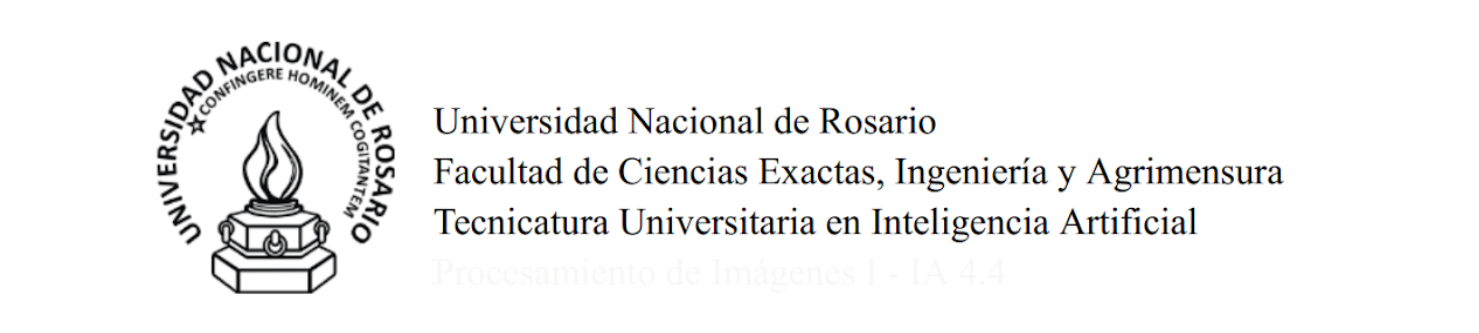

# Trabajo Práctico Final: Procesamiento de Lenguaje Natural.

- **Nancy Lucía Cima**
- **C-7379/2**

Docentes:
 - Manson, Juan Pablo.
 - Geary, Alan.
 - Sollberger, Dolores.
 - Ferrucci, Costantino.


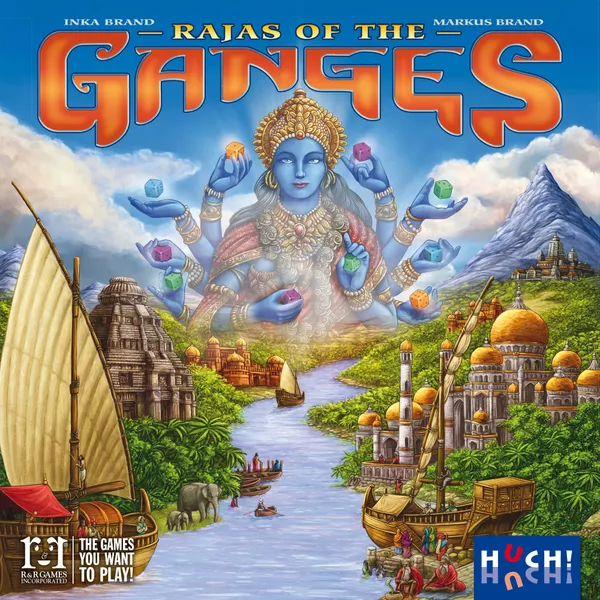

El objetivo de este trabajo es crear un chatbot experto en un juego de mesa Rajas de Ganges, usando la técnica RAG (Retrieval Augmented Generation). Como fuentes de
conocimiento se utilizarán al menos las siguientes fuentes:

- Documentos de texto
- Datos numéricos en formato tabular (por ej., Dataframes, CSV, sqlite, etc.)
- Base de datos de grafos (Online o local) El sistema debe poder llevar a cabo una conversación en lenguaje español o inglés.

El usuario podrá hacer preguntas, que el chatbot intentará responder a partir de datos de algunas de sus fuentes. El asistente debe poder clasificar las preguntas, para saber qué fuentes de datos utilizar como contexto para generar una respuesta. Se espera que las respuestas del chatbot sean en el mismo lenguaje de la consulta del usuario.

Primero, instalamos e importamos los recursos y librerías necesarias.

In [ ]:
# Redis graph
%%capture
!pip install redis redisgraph
!wget http://nz2.archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2_amd64.deb
!sudo dpkg -i libssl1.1_1.1.1f-1ubuntu2_amd64.deb
!curl -fsSL https://packages.redis.io/redis-stack/redis-stack-server-6.2.6-v7.focal.x86_64.tar.gz -o redis-stack-server.tar.gz
!tar -xvf redis-stack-server.tar.gz
!./redis-stack-server-6.2.6-v7/bin/redis-stack-server --daemonize yes


import redis
from redisgraph import Graph, Node, Edge
import matplotlib.pyplot as plt
import networkx as nx

# Selenium web scrapping
!apt-get update
!apt-get install -y chromium-browser chromium-chromedriver
!pip install selenium

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

import os
os.environ["PATH"] += ":/usr/bin/chromedriver"

# Detección de idioma
!pip install langdetect
import langdetect

# Extracción de texto desde Documentos
!pip install PyPDF2
import PyPDF2
from PyPDF2 import PdfReader
!pip install gdown
import re

# Visualización
import matplotlib.pyplot as plt
import networkx as nx

# DataFrame
import pandas as pd
import numpy as np

# Requests (Descarga de PDF)
import requests

# YouTube Transcripción
!pip install youtube-transcript-api
from youtube_transcript_api import YouTubeTranscriptApi

# Traduccion
!pip install googletrans==3.1.0a0

# Guardar la base de datos de grafo
import xml.etree.ElementTree as ET

# Base de datos vectorial
!pip install -U langchain-community
import langchain
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings

# Chromadb
!pip install chromadb
import chromadb
from chromadb import Client, Settings

# Para tener id's en la chroma
import uuid

# Redes neuronales - Transformers
!pip install -U tokenizers
!pip install rank_bm25
import torch
from transformers import AutoModel, AutoTokenizer
from nltk.tokenize import word_tokenize
from rank_bm25 import BM25Okapi

# Clasificador mediante regresión logística
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, recall_score, f1_score
import nltk

# Modelo de lenguaje HuggingFace (HF)
!pip install -U huggingface_hub
from huggingface_hub import InferenceClient

# data para API KEY
from google.colab import userdata

from typing import List, Tuple, Dict

Luego, pasaremos a crear las diferentes fuentes de datos.

# Base de Datos de Grafo

Una **base de datos de grafos** es un tipo de base de datos que utiliza la teoría de grafos para almacenar, organizar y consultar datos. En lugar de almacenar los datos en tablas como en las bases de datos relacionales tradicionales, en una base de datos de grafos, los datos se representan como **nodos**, **aristas** (o **bordes**) y **propiedades**.

Son ideales para modelar relaciones complejas y dinámicas entre los datos. En lugar de manejar relaciones implícitas como en las bases de datos relacionales, en las bases de datos de grafos estas relaciones están explícitamente representadas como aristas.

Así, las consultas que implican la exploración de conexiones entre los datos.

En este caso, la utilizaremos para modelar datos acerca del juego que no tienen que ver de manera estricta con su jugabilidad, sino más bien relaciones entre distintas personas, otros juegos, premios y nacionalidades.

## Web scrapping

Antes de armar la base de datos de grafos, obtendremos la información a través de Web Scrapping con Selenium.

En particular, obtendremos informacion de:
- Diseñadores.
- Artistas.
- Familia de Juegos.
- Mecanismos.
- Empresas que lo publicaron.
- Categorias.
- Nombres alternativos para el juego.

Primeramente se debe extraer la información. Se encuentran todos los links necesarios para obtener información pertinente para la base de grafos.

In [2]:
def configure_driver() -> webdriver.Chrome:
    """Configura y retorna un driver de Selenium en modo headless."""
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--no-sandbox")
    return webdriver.Chrome(service=Service(), options=chrome_options)

def search_elements(driver: webdriver.Chrome, data: str, xpath_templates: List[str]) -> Tuple[Dict[str, List[str]], Dict[str, List[str]]]:
    """
    Busca elementos según los XPaths proporcionados y retorna diccionarios con nombres y links.

    Args:
        driver: webdriver.Chrome = instancia del driver de Selenium.
        data: str = el nombre del dato a buscar.
        xpath_templates: List[str] = lista de plantillas de XPaths para buscar elementos.

    Returns:
        name_dict: Dict[str, List[str]] = diccionario con los nombres.
        link_dict: Dict[str, List[str]] = diccionario con los links.
    """
    name_dict = {f"{data}_nombre": []}
    link_dict = {f"{data}_link": []}

    for xpath_template in xpath_templates:
        elements = driver.find_elements(By.XPATH, xpath_template.format(data=data))
        if elements:
            for element in elements:
                name_dict[f"{data}_nombre"].append(element.text)
                link_dict[f"{data}_link"].append(element.get_attribute('href'))
            break  # Si encuentra elementos, no sigue buscando

    if not name_dict[f"{data}_nombre"]:  # Si no se encontraron elementos
        print(f"No se encontraron elementos para {data}")

    return name_dict, link_dict

def search_section(data: str) -> Tuple[Dict[str, List[str]], Dict[str, List[str]]]:
    """
    Retorna una tupla de diccionarios que contienen el(los) nombre(s) y el link(s) correspondiente(s).

    Args:
        data: str = el nombre del dato a buscar.

    Returns:
        name_dict: Dict[str, List[str]] = diccionario con los nombres.
        link_dict: Dict[str, List[str]] = diccionario con los links.
    """
    url_grafo: str = "https://boardgamegeek.com/boardgame/220877/rajas-of-the-ganges/credits"
    driver = configure_driver()
    driver.get(url_grafo)

    xpath_templates = [
        '//a[contains(@ng-href, "/boardgame{data}/")]',
        "//div[@ng-switch-when='alternatename']"
    ]

    try:
        name_dict, link_dict = search_elements(driver, data, xpath_templates)
    except Exception as e:
        print(f"Error al buscar elementos para {data}: {e}")
        name_dict, link_dict = {f"{data}_nombre": []}, {f"{data}_link": []}
    finally:
        driver.quit()

    return name_dict, link_dict


In [3]:
data_designer = search_section("designer")
data_artist = search_section("artist")
data_family = search_section("family")
data_mechanic = search_section("mechanic")
data_publisher = search_section("publisher")
data_categories = search_section("category")
data_alternative_names = search_section("alternatename")

In [4]:
data_designer

({'designer_nombre': ['Inka Brand', 'Markus Brand']},
 {'designer_link': ['https://boardgamegeek.com/boardgamedesigner/6940/inka-brand',
   'https://boardgamegeek.com/boardgamedesigner/6941/markus-brand']})

In [5]:
data_artist

({'artist_nombre': ['Dennis Lohausen']},
 {'artist_link': ['https://boardgamegeek.com/boardgameartist/12484/dennis-lohausen']})

In [6]:
data_family

({'family_nombre': ['Admin: Better Description Needed!',
   'Country: India',
   'Digital Implementations: Tabletopia',
   'Digital Implementations: Yucata',
   'Game: Rajas of the Ganges',
   'Mechanism: Dice Drafting',
   'Religious: Hinduism']},
 {'family_link': ['https://boardgamegeek.com/boardgamefamily/22783/admin-better-description-needed',
   'https://boardgamegeek.com/boardgamefamily/9961/country-india',
   'https://boardgamegeek.com/boardgamefamily/70948/digital-implementations-tabletopia',
   'https://boardgamegeek.com/boardgamefamily/70354/digital-implementations-yucata',
   'https://boardgamegeek.com/boardgamefamily/56993/game-rajas-of-the-ganges',
   'https://boardgamegeek.com/boardgamefamily/65163/mechanism-dice-drafting',
   'https://boardgamegeek.com/boardgamefamily/73578/religious-hinduism']})

In [7]:
data_mechanic

({'mechanic_nombre': ['Connections',
   'Dice Rolling',
   'Race',
   'Tile Placement',
   'Track Movement',
   'Worker Placement',
   'Worker Placement with Dice Workers']},
 {'mechanic_link': ['https://boardgamegeek.com/boardgamemechanic/2883/connections',
   'https://boardgamegeek.com/boardgamemechanic/2072/dice-rolling',
   'https://boardgamegeek.com/boardgamemechanic/2876/race',
   'https://boardgamegeek.com/boardgamemechanic/2002/tile-placement',
   'https://boardgamegeek.com/boardgamemechanic/2939/track-movement',
   'https://boardgamegeek.com/boardgamemechanic/2082/worker-placement',
   'https://boardgamegeek.com/boardgamemechanic/2935/worker-placement-with-dice-workers']})

In [8]:
data_publisher

({'publisher_nombre': ['HUCH!',
   '999 Games',
   'Devir',
   'Dice Realm',
   'DV Games',
   'Egmont Polska',
   'Fabrika Igr',
   'Game Harbor',
   'HOT Games',
   'nostalgia (III)',
   'R&R Games']},
 {'publisher_link': ['https://boardgamegeek.com/boardgamepublisher/3490/huch',
   'https://boardgamegeek.com/boardgamepublisher/267/999-games',
   'https://boardgamegeek.com/boardgamepublisher/2366/devir',
   'https://boardgamegeek.com/boardgamepublisher/46544/dice-realm',
   'https://boardgamegeek.com/boardgamepublisher/917/dv-games',
   'https://boardgamegeek.com/boardgamepublisher/7496/egmont-polska',
   'https://boardgamegeek.com/boardgamepublisher/37681/fabrika-igr',
   'https://boardgamegeek.com/boardgamepublisher/12540/game-harbor',
   'https://boardgamegeek.com/boardgamepublisher/17130/hot-games',
   'https://boardgamegeek.com/boardgamepublisher/52507/nostalgia-iii',
   'https://boardgamegeek.com/boardgamepublisher/105/r-and-r-games']})

In [9]:
data_categories

({'category_nombre': ['Dice',
   'Economic',
   'Renaissance',
   'Territory Building']},
 {'category_link': ['https://boardgamegeek.com/boardgamecategory/1017/dice',
   'https://boardgamegeek.com/boardgamecategory/1021/economic',
   'https://boardgamegeek.com/boardgamecategory/1070/renaissance',
   'https://boardgamegeek.com/boardgamecategory/1086/territory-building']})

In [10]:
data_alternative_names

({'alternatename_nombre': ['Ganges',
   'I Ragià del Gange',
   "Raja's van de Ganges",
   'Раджи Ганга',
   'ガンジスの藩王',
   '갠지스의 라자']},
 {'alternatename_link': [None, None, None, None, None, None]})

Agregaremos el idioma correspondiente a cada nombre alternativo del juego.

In [11]:
# Detectar idioma de nombres alternativos
data_alternative_names_lang = []
for alt_name_dict in data_alternative_names:
    if 'alternatename_nombre' in alt_name_dict:
        alt_names = alt_name_dict['alternatename_nombre']
        languages = []
        for alt_name in alt_names:
            try:
                lang = langdetect.detect(alt_name)
                languages.append(lang)
            except langdetect.lang_detect_exception.LangDetectException:
                print(f"No se pudo detectar el idioma para: {alt_name}")
        data_alternative_names_lang.append({
            'Alternative_Name': alt_names,
            'Language': languages
        })

print(data_alternative_names_lang)

[{'Alternative_Name': ['Ganges', 'I Ragià del Gange', "Raja's van de Ganges", 'Раджи Ганга', 'ガンジスの藩王', '갠지스의 라자'], 'Language': ['de', 'ca', 'nl', 'bg', 'ja', 'ko']}]


## Creación de la base de datos de Grafos


Ahora que ya tenemos los datos a ultilizar en la base de datos de grafos, pasaremos a crearla. Para ello utilizaremos Redis, por su simple implementación con Colab.

Primero, inicializatemos de Redis.

In [12]:
redis_client = redis.Redis(host='localhost', port=6379)

Crearemos funciones que nos ayudaran con la creacion, visualizacion y acceso a la base de datos de grafos.

In [14]:
def define_relation(label: str) -> str:
    # Definir relaciones según el label
    relations = {
        "Designer": "Designed_by",
        "Artist": "Created_by",
        "Family": "Similar_to",
        "Mechanic": "Mechanic",
        "Publisher": "Published_by",
        "Category": "Classified_as",
        "Alternative": "Also_known_as",
        "Language": "Written_in"
    }
    return relations.get(label, "Undefined_relationship")


def create_nodes_with_relations(graph: Graph, data: dict[str, list[str]], main_node: Node) -> None:
    """
    Dado un diccionario con datos, crea los nodos correspondientes en un grafo
    de Redis y añade las relaciones correspondientes.

    Args:
        graph: Instancia del grafo de Redis.
        data: Diccionario que contiene nombres como listas bajo claves específicas.
        main_node: Nodo principal para relacionar con los nuevos nodos.

    Returns:
        None
    """
    if not data:
        print("Diccionario vacío. No se crearon nodos ni relaciones.")
        return

    for key, names in data.items():
        label = key.split("_")[0].capitalize()
        relation = define_relation(label)

        if not relation:
            print(f"Relación no definida para el label: {label}")
            continue

        for name in names:
            print(f"Creando nodo con nombre: {name} y label: {label}")
            node = Node(label=label, properties={"name": name})
            graph.add_node(node)

            print(f"Añadiendo relación: {relation}")
            edge = Edge(main_node, relation, node)
            graph.add_edge(edge)

    print("Nodos y relaciones creados exitosamente.")


def create_all_nodes(graph: Graph, title: str, datasets: list[dict[str, list[str]]]) -> None:
    """
    Crea todos los nodos y sus relaciones en el grafo a partir de múltiples datasets.

    Args:
        graph: Instancia del grafo de Redis.
        title: Título del nodo principal.
        datasets: Lista de diccionarios con datos para crear nodos y relaciones.

    Returns:
        None
    """
    main_node = Node(label="Title", properties={"name": title})
    graph.add_node(main_node)

    for data in datasets:
        # Comprueba si los datos son una tupla e itera a través de sus elementos
        if isinstance(data, tuple):
            for item in data:
                if isinstance(item, dict):  # Comprueba que cada elemento es un dict
                    create_nodes_with_relations(graph, item, main_node)
        else: #si no es una tupla, se trata como antes
            create_nodes_with_relations(graph, data, main_node)

    # Procesar nombres alternativos y idiomas
    for data in datasets:
        if isinstance(data, tuple):
            for item in data:
                if isinstance(item, dict):
                    if "Alternative_Name" in item and "Language" in item:
                        for i, name in enumerate(item["Alternative_Name"]):
                            lang_name = item["Language"][i]

                            # Crear nodo de Alternate Name
                            alternate_name_node = Node(label="Alternate_Name", properties={"name": name})
                            graph.add_node(alternate_name_node)

                            # Crear nodo de Language (si no existe)
                            language_node = Node(label="Language", properties={"name": lang_name})
                            existing_language_nodes = graph.query(f"MATCH (n:Language {{name: '{lang_name}'}}) RETURN n").result_set
                            if not existing_language_nodes:
                                graph.add_node(language_node)
                            else:
                                language_node = existing_language_nodes[0][0]

                            # Crear relación entre el nodo de Alternate Name y el nodo de idioma
                            edge = Edge(alternate_name_node, "Written_in", language_node)
                            graph.add_edge(edge)

    graph.commit()
    print("Todos los nodos y relaciones han sido creados y confirmados.")


def get_all_nodes(graph: Graph) -> list[dict]:
    """
    Recupera todos los nodos del grafo.

    Args:
        graph: Instancia del grafo de Redis.

    Returns:
        Lista de diccionarios con la información de cada nodo (id, label, properties).
    """
    query = "MATCH (n) RETURN n"
    result = graph.query(query)
    nodes = []

    for record in result.result_set:
        node = record[0]
        nodes.append({
            "id": node.id,
            "label": node.label,
            "properties": node.properties
        })

    return nodes


def plot_graph(graph: Graph) -> None:
    """
    Genera una visualización del grafo de Redis con nodos y relaciones.

    Args:
        graph: Instancia del grafo de Redis.

    Returns:
        None
    """
    import networkx as nx
    import matplotlib.pyplot as plt

    nx_graph = nx.DiGraph()

    # Consultar nodos
    node_query = "MATCH (n) RETURN n"
    node_result = graph.query(node_query)

    for record in node_result.result_set:
        node = record[0]
        node_id = node.id
        node_label = node.label
        node_name = node.properties.get("name", f"Node {node_id}")
        nx_graph.add_node(node_id, label=node_label, name=node_name, category=node_label)

    # Consultar relaciones
    edge_query = "MATCH (n)-[r]->(m) RETURN n, r, m"
    edge_result = graph.query(edge_query)

    for record in edge_result.result_set:
        src = record[0].id
        dest = record[2].id
        relationship = record[1]

        relation_type = getattr(relationship, 'relation', 'undefined')
        relation_properties = getattr(relationship, 'properties', {})

        nx_graph.add_edge(src, dest, label=relation_type)

    # Visualizar grafo
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(nx_graph, k=0.5)

    # Colorear nodos por categoría
    categories = nx.get_node_attributes(nx_graph, 'category')
    unique_categories = set(categories.values())
    node_colors = {cat: plt.cm.tab10(i / len(unique_categories)) for i, cat in enumerate(unique_categories)}
    node_color_list = [node_colors[categories[node]] for node in nx_graph.nodes()]

    nx.draw(
        nx_graph, pos,
        with_labels=False,
        node_size=700,
        node_color=node_color_list,
        edge_color='gray',
        alpha=0.7
    )

    # Etiquetas de nodos
    node_labels = {node: data['name'] for node, data in nx_graph.nodes(data=True)}
    nx.draw_networkx_labels(nx_graph, pos, labels=node_labels, font_size=8, font_color='black')

    # Etiquetas de relaciones
    edge_labels = nx.get_edge_attributes(nx_graph, "label")
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_size=6)

    # Leyenda de categorías
    legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=cat)
                     for cat, color in node_colors.items()]
    plt.legend(handles=legend_labels, loc='best', title='Categorías')

    plt.title("Grafo de Redis: Nodos y Relaciones")
    plt.show()
    plt.clf()  # Limpia la figura actual después de mostrar
    plt.close()  # Cierra la figura actual para evitar la superposición de graficos


def get_graph_data(graph: Graph) -> dict:
    """
    Recupera datos estructurados del grafo, incluyendo nodos y relaciones.

    Args:
        graph: Instancia del grafo de Redis.

    Returns:
        Diccionario con listas de nodos y relaciones.
    """
    graph_data = {
        "nodes": [],
        "relationships": []
    }

    # Consultar nodos
    node_query = "MATCH (n) RETURN n"
    node_result = graph.query(node_query)

    for record in node_result.result_set:
        node = record[0]
        graph_data["nodes"].append({
            "id": node.id,
            "label": node.label,
            "properties": node.properties
        })

    # Consultar relaciones
    edge_query = "MATCH (n)-[r]->(m) RETURN n, r, m"
    edge_result = graph.query(edge_query)

    for record in edge_result.result_set:
        src = record[0].id
        dest = record[2].id
        relationship = record[1]

        relation_type = getattr(relationship, 'relation', 'undefined')
        relation_properties = getattr(relationship, 'properties', {})

        graph_data["relationships"].append({
            "source": src,
            "target": dest,
            "type": relation_type,
            "properties": relation_properties
        })

    return graph_data


Ejecutamos las funiones realizadas

Creando nodo con nombre: Inka Brand y label: Designer
Añadiendo relación: Designed_by
Creando nodo con nombre: Markus Brand y label: Designer
Añadiendo relación: Designed_by
Nodos y relaciones creados exitosamente.
Creando nodo con nombre: Dennis Lohausen y label: Artist
Añadiendo relación: Created_by
Nodos y relaciones creados exitosamente.
Creando nodo con nombre: Admin: Better Description Needed! y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Country: India y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Digital Implementations: Tabletopia y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Digital Implementations: Yucata y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Game: Rajas of the Ganges y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Mechanism: Dice Drafting y label: Family
Añadiendo relación: Similar_to
Creando nodo con nombre: Religious: Hinduism y label: Fa

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12460 (\N{KATAKANA LETTER GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12472 (\N{KATAKANA LETTER ZI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPytho

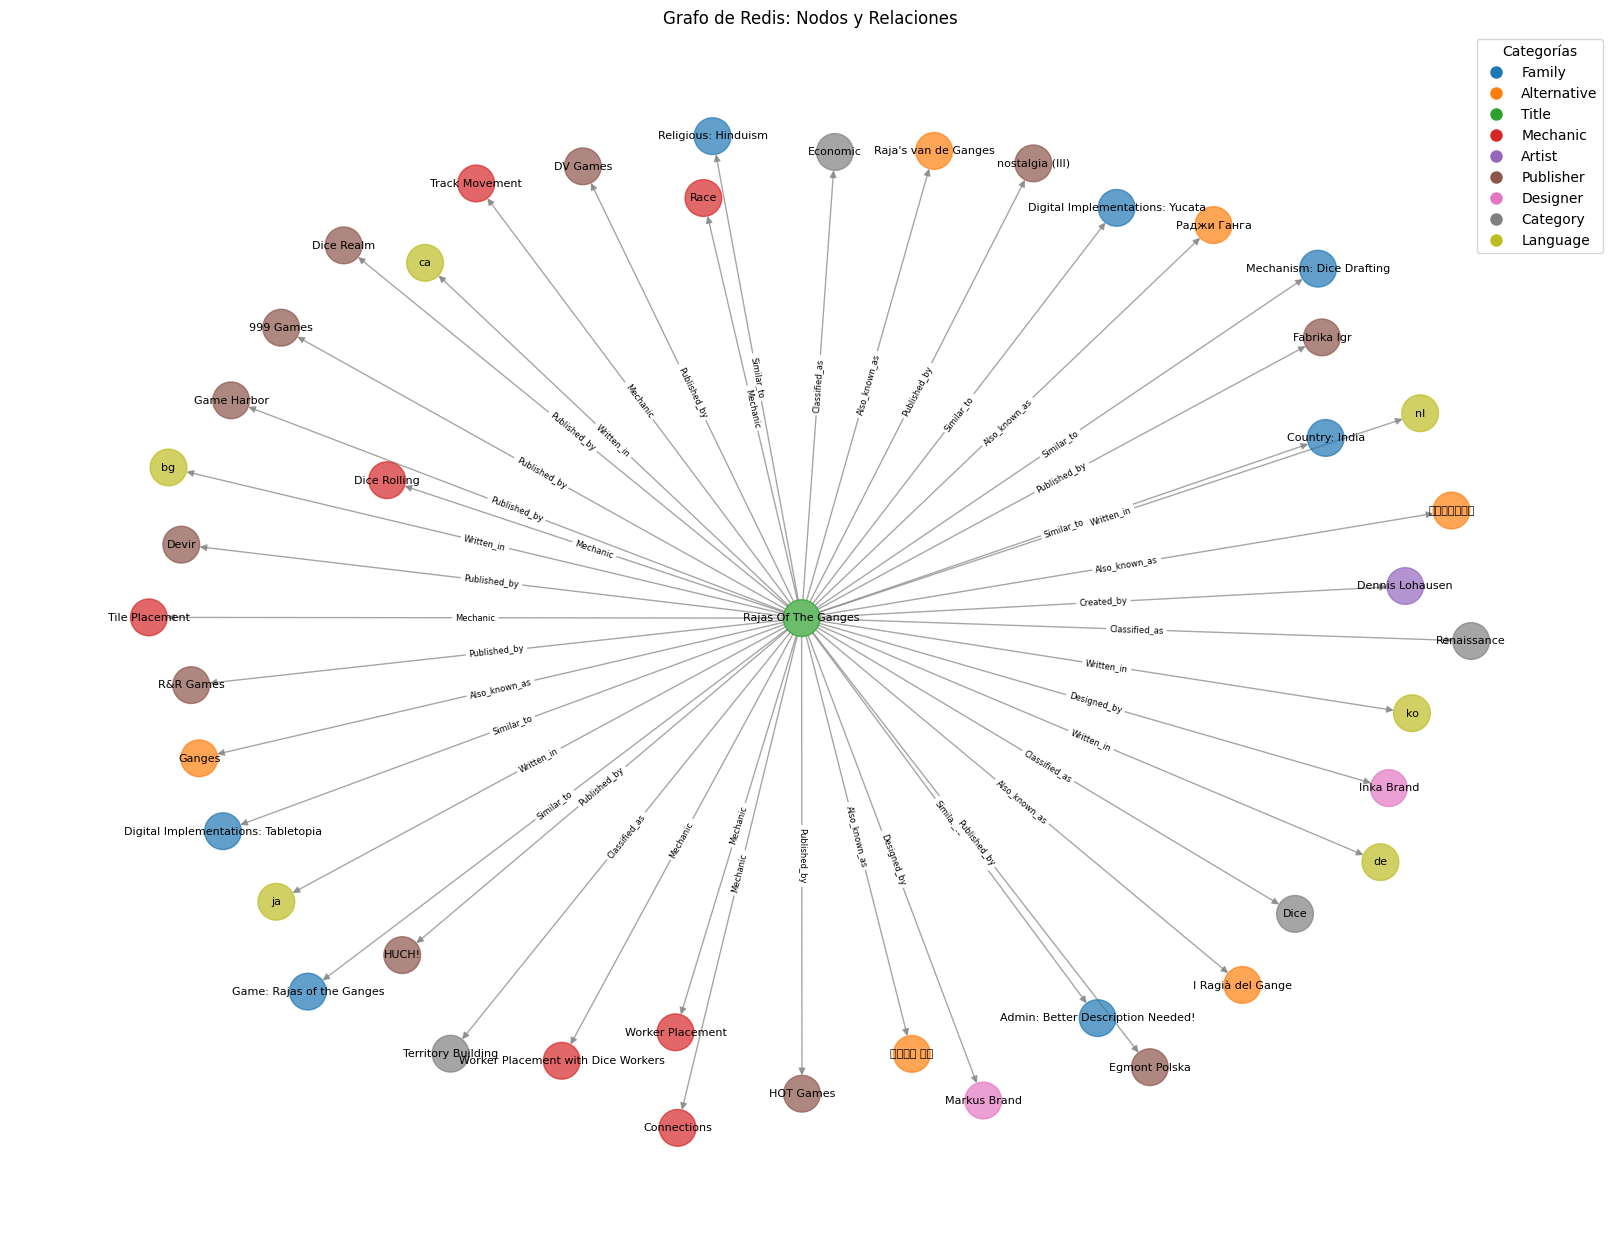

{'nodes': [{'id': 0, 'label': 'Title', 'properties': {'name': 'Rajas Of The Ganges'}}, {'id': 1, 'label': 'Designer', 'properties': {'name': 'Inka Brand'}}, {'id': 2, 'label': 'Designer', 'properties': {'name': 'Markus Brand'}}, {'id': 3, 'label': 'Artist', 'properties': {'name': 'Dennis Lohausen'}}, {'id': 4, 'label': 'Family', 'properties': {'name': 'Admin: Better Description Needed!'}}, {'id': 5, 'label': 'Family', 'properties': {'name': 'Country: India'}}, {'id': 6, 'label': 'Family', 'properties': {'name': 'Digital Implementations: Tabletopia'}}, {'id': 7, 'label': 'Family', 'properties': {'name': 'Digital Implementations: Yucata'}}, {'id': 8, 'label': 'Family', 'properties': {'name': 'Game: Rajas of the Ganges'}}, {'id': 9, 'label': 'Family', 'properties': {'name': 'Mechanism: Dice Drafting'}}, {'id': 10, 'label': 'Family', 'properties': {'name': 'Religious: Hinduism'}}, {'id': 11, 'label': 'Mechanic', 'properties': {'name': 'Connections'}}, {'id': 12, 'label': 'Mechanic', 'prope

In [15]:
graph = Graph('creditos', redis_client)

title = "Rajas Of The Ganges"
datasets = [data_designer[0], data_artist[0], data_family[0], data_mechanic[0], data_publisher[0], data_categories[0], data_alternative_names_lang[0]]

# Crear nodos y relaciones
create_all_nodes(graph, title, datasets)

# Recuperar y mostrar todos los nodos
all_nodes = get_all_nodes(graph)
for node in all_nodes:
    print(node)

# Visualizar el grafo
plot_graph(graph)

# Obtener datos estructurados del grafo
graph_data = get_graph_data(graph)
print(graph_data)

Probaremos hacer una consulta a la base de datos de grafo.

In [16]:
def query_graph_database(graph: Graph, query_string: str) -> list:
    """
    Ejecuta una consulta Cypher en la base de datos de grafos y devuelve los resultados.

    Args:
        graph: Instancia del grafo de Redis.
        query_string: La consulta Cypher a ejecutar.

    Returns:
        Una lista de diccionarios, donde cada diccionario representa un registro de resultado.
    """
    try:
        result = graph.query(query_string)
        return result.result_set
    except Exception as e:
        print(f"Error al ejecutar la consulta: {e}")
        return []

In [17]:
# Consulta para obtener todos los diseñadores del juego
query = "MATCH (t:Title {name: 'Rajas Of The Ganges'})-[:Designed_by]->(d:Designer) RETURN d.name"
results = query_graph_database(graph, query)

print("Resultados de la consulta:")
for record in results:
    print(record[0])  # Imprime el nombre de cada diseñador

Resultados de la consulta:
Inka Brand
Markus Brand


Guardaremos nustra base de datos de grafo como un archivo XML.

In [18]:
def save_graph_to_xml(graph_data, file_path):
    """Guarda grafo a un archivo XML.

    Args:
        graph_data: Un diccionario que representa los datos del grafo
        file_path: Ruta de acceso al archivo XML.
    """
    # Crea el elemento raíz del archivo XML
    root = ET.Element("graph")

    # Agrega los nodos al archivo XML
    for node in graph_data["nodes"]:
        node_element = ET.SubElement(root, "node")
        node_element.set("id", str(node["id"]))
        node_element.set("label", node["label"])
        for key, value in node["properties"].items():
            property_element = ET.SubElement(node_element, "property")
            property_element.set("name", key)
            property_element.set("value", value)

    # Agrega las relaciones al archivo XML
    for relationship in graph_data["relationships"]:
        relationship_element = ET.SubElement(root, "relationship")
        relationship_element.set("source", str(relationship["source"]))
        relationship_element.set("target", str(relationship["target"]))
        relationship_element.set("type", relationship["type"])
        for key, value in relationship["properties"].items():
            property_element = ET.SubElement(relationship_element, "property")
            property_element.set("name", key)
            property_element.set("value", value)

    # Escribe el archivo XML
    tree = ET.ElementTree(root)
    tree.write(file_path, encoding="utf-8", xml_declaration=True)

Llamamos a la funcion 'save_graph_to_xml'

In [19]:
file_path = "/content/drive/My Drive/databases/graph_db.xml"
os.makedirs(os.path.dirname(file_path), exist_ok=True)

graph_data = get_graph_data(graph)
save_graph_to_xml(graph_data, file_path)

#  Base de Datos Tabular

Una base de datos tabular es un tipo de base de datos que organiza los datos en tablas estructuradas de manera similar a una hoja de cálculo o a una base de datos relacional. Cada tabla en una base de datos tabular está compuesta por filas y columnas, donde las filas representan registros o entidades y las columnas representan atributos o campos que describen esos registros.

En este caso, almacenaremos estadisticas relacionadas al juego en una base de datos tabular. Estas estaditicas son, por ejemplo:
- Rating Promedio
- Numero de Ratings
- Desvio Estaandar
- Comentarios
- Fans
- Visitas a la pagina
- Game Ranks
- etc

Podemos encontrar esos datos en la siguiente pagina:

In [20]:
url_stats = 'https://boardgamegeek.com/boardgame/220877/rajas-of-the-ganges/stats'

In [21]:
def get_stats(url: str) -> Dict[str, str]:
    """
    Dado un URL, obtiene las estadísticas de un juego.

    Args:
        url: URL de las estadísticas.

    Returns:
        Un diccionario con las estadísticas extraídas.
    """
    # Configuración del navegador sin interfaz gráfica
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")

    # Inicia el navegador con las opciones configuradas
    driver = webdriver.Chrome(service=Service(), options=chrome_options)

    try:
        # Accede a la URL proporcionada
        driver.get(url)

        # Espera hasta que los elementos sean visibles
        WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'li.outline-item'))
        )

        stats: Dict[str, str] = {}

        # Extrae los elementos relevantes
        elements = driver.find_elements(By.CSS_SELECTOR, 'li.outline-item')

        for element in elements:
            try:
                main_text_element = element.find_element(By.CSS_SELECTOR, 'div.outline-item-title')
                main_text = main_text_element.text.strip()

                sub_value = element.find_element(By.CSS_SELECTOR, 'div.outline-item-description').text.strip()

                stats[main_text] = sub_value
            except Exception as inner_e:
                print(f"Error extracting data for an element: {inner_e}")

    except Exception as e:
        print(f"Error extracting stats: {e}")
    finally:
        # Cierra el navegador independientemente de si ocurre un error o no
        driver.quit()

    return stats

Ejecutamos el codigo

In [152]:
# Extraemos e imprimimos las estadísticas
stats = get_stats(url_stats)
stats

In [153]:
# Pasaremos a formato DataFrame para su posterior manipulacion
df_stats = pd.DataFrame(stats, index=[0])
df_stats

,Avg. Rating,No. of Ratings,Std. Deviation,Weight,Comments,Fans,Page Views,Overall Rank,Strategy Rank,All Time Plays,This Month,Own,Prev. Owned,For Trade,Want In Trade,Wishlist,Has Parts,Want Parts
0,7.731,"14,702",1.13,2.89 / 5,"2,125",691,"899,914",156\nHistorical Rank,123\nHistorical Rank,"59,439",232,"19,560","2,058",194\nFind For-Trade Matches,676\nFind Want-in-Trade Matches,"3,810",11,4


In [154]:
df_stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 0 to 0
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Avg. Rating     1 non-null      object
 1   No. of Ratings  1 non-null      object
 2   Std. Deviation  1 non-null      object
 3   Weight          1 non-null      object
 4   Comments        1 non-null      object
 5   Fans            1 non-null      object
 6   Page Views      1 non-null      object
 7   Overall Rank    1 non-null      object
 8   Strategy Rank   1 non-null      object
 9   All Time Plays  1 non-null      object
 10  This Month      1 non-null      object
 11  Own             1 non-null      object
 12  Prev. Owned     1 non-null      object
 13  For Trade       1 non-null      object
 14  Want In Trade   1 non-null      object
 15  Wishlist        1 non-null      object
 16  Has Parts       1 non-null      object
 17  Want Parts      1 non-null      object
dtypes: object(18)
memor

In [155]:
def clean_dataframe(df):
    """
    Elimina los caracteres de salto de línea y reemplaza las comas por puntos en las columnas
    numéricas de un DataFrame.

    Args:
        df: El DataFrame de entrada.

    Returns:
        El DataFrame limpio.
    """
    df = df.replace(r'\n',' ', regex=True) #reemplazo \n por un espacio en blanco
    for col in df.columns:
        try:
            # Trato de convertir la columana a tipo numerica
            df[col] = pd.to_numeric(df[col].str.replace(',', '', regex=False))
        except (ValueError, AttributeError):
            pass
    return df

# Llamo a la funcion para limpiar el df
df_stats = clean_dataframe(df_stats)
df_stats

,Avg. Rating,No. of Ratings,Std. Deviation,Weight,Comments,Fans,Page Views,Overall Rank,Strategy Rank,All Time Plays,This Month,Own,Prev. Owned,For Trade,Want In Trade,Wishlist,Has Parts,Want Parts
0,7.731,14702,1.13,2.89 / 5,2125,691,899914,156 Historical Rank,123 Historical Rank,59439,232,19560,2058,194 Find For-Trade Matches,676 Find Want-in-Trade Matches,3810,11,4


In [156]:
df_stats.columns

Index(['Avg. Rating', 'No. of Ratings', 'Std. Deviation', 'Weight', 'Comments',
       'Fans', 'Page Views', 'Overall Rank', 'Strategy Rank', 'All Time Plays',
       'This Month', 'Own', 'Prev. Owned', 'For Trade', 'Want In Trade',
       'Wishlist', 'Has Parts', 'Want Parts'],
      dtype='object')

Cambiaremos el nombre de las columnas por nombres mas extensos y descriptivos.

In [157]:
columns_renamed: dict[str, str] = {
    'Avg. Rating': 'average_rating',
    'No. of Ratings': 'number_of_rating',
    'Std. Deviation' : 'std',
    'Weight' : 'weight',
    'Comments' : 'comments',
    'Fans' : 'fans',
    'Page Views' : 'page_views',
    'Overall Rank': 'overall_rank',
    'Strategy Rank' : 'strategy_rank',
    'All Time Plays' : 'all_time_plays',
    'This Month' : 'this_month',
    'Own': 'own',
    'Prev. Owned' : 'owned_no_longer',
    'For Trade' : 'items_for_trade',
    'Want In Trade' : 'items_want_in_trade',
    'Wishlist' : 'wishlist',
    'Has Parts' :'people_who_has_parts_to_exchange',
    'Want Parts' : 'people_who_want_parts_to_exchange'

}

df_stats_renamed = pd.DataFrame(df_stats.rename(columns=columns_renamed))
df_stats_renamed

,average_rating,number_of_rating,std,weight,comments,fans,page_views,overall_rank,strategy_rank,all_time_plays,this_month,own,owned_no_longer,items_for_trade,items_want_in_trade,wishlist,people_who_has_parts_to_exchange,people_who_want_parts_to_exchange
0,7.731,14702,1.13,2.89 / 5,2125,691,899914,156 Historical Rank,123 Historical Rank,59439,232,19560,2058,194 Find For-Trade Matches,676 Find Want-in-Trade Matches,3810,11,4


Pasamos de fomato ancho a formato largo

In [158]:
df_stats_long = pd.melt(df_stats_renamed, var_name='Stat', value_name='Value')
df_stats_long

,Stat,Value
0,average_rating,7.731
1,number_of_rating,14702
2,std,1.13
3,weight,2.89 / 5
4,comments,2125
5,fans,691
6,page_views,899914
7,overall_rank,156 Historical Rank
8,strategy_rank,123 Historical Rank
9,all_time_plays,59439


Guardamos en un archivo de fomato .csv

In [159]:
# Definimos la ruta del directorio donde guardaremos el archivo CSV
directory_path = '/content/drive/My Drive/databases'

# Creamos el directorio si no existe
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Guardamos el DataFrame a CSV en un directorio
file_path = os.path.join(directory_path, 'tabular_db.csv')
df_stats_long.to_csv(file_path, index=False)

print(f"DataFrame guardado en: {file_path}")

DataFrame guardado en: /content/drive/My Drive/databases/tabular_db.csv


# Base de Datos Vectorial

Una base de datos vectorial es un tipo de base de datos diseñada para almacenar, gestionar y consultar vectores. Los vectores son representaciones matemáticas de datos en un espacio multidimensional. Este tipo de base de datos es comúnmente utilizada en aplicaciones de búsqueda y recuperación de información basadas en similitud, como la búsqueda de texto, imágenes o audio, donde los datos son convertidos en vectores para poder comparar su similitud de manera eficiente.

En nuestra base de datos vectorial almacenaremos docuemntos de texto en formato PDF, videos de tutoriales y reseñas y opiniones del juego encontradas en foro. Para esto, primero deberemos obtener los datos y procesarlos.

## Documentos de texto

Una de las fuentes de datos que utilizaremos son documentos de texto, como los reglamentos del juego.

Para ello, importamos archivos a utilizar.

In [29]:
def limpiar_texto(texto):
    # Eliminar caracteres no codificados (\uXXXX, \xXX, etc.)
    texto = re.sub(r'\\u[0-9a-fA-F]{4}|\\x[0-9a-fA-F]{2}', '', texto)
    # Eliminar caracteres no alfanuméricos (excepto básicos como espacios, puntuación común)
    texto = re.sub(r'[^a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ\s.,;!?()-]', '', texto)
    # Eliminar espacios múltiples
    texto = re.sub(r'\s+', ' ', texto)
    # Manejar espacios
    texto = texto.replace('\uf0a7', '')
    texto = texto.replace('\n', ' ')
    # Quitar espacios iniciales y finales
    texto = texto.strip()
    return texto

In [30]:
# Ruta de la carpeta en Google Drive
carpeta_id = '1fWzvMI3rdWzjG1vkwj191CdDBEJQjp9L'

# Crear el directorio para descargar los archivos
!mkdir ./archivos

# Descargar los archivos de la carpeta
!gdown --folder {carpeta_id} --output ./archivos

# Extraer texto de los archivos PDF descargados
for archivo in os.listdir('./archivos'):
    if archivo.endswith('.pdf'):
        nombre_archivo = archivo
        print('Extrayendo texto de', nombre_archivo)

        # Abrir el archivo PDF
        pdf_file = open(os.path.join('./archivos', nombre_archivo), 'rb')
        pdf_reader = PdfReader(pdf_file)
        num_paginas = len(pdf_reader.pages)
        texto = ''
        for pagina in range(num_paginas):
           pagina_texto = pdf_reader.pages[pagina].extract_text()
           texto += limpiar_texto(pagina_texto)
        pdf_file.close()

        # Guardar el texto extraído como variable
        variable_name = nombre_archivo.replace('.pdf', '_text')
        if nombre_archivo == 'Rajas_of_the_Ganges_Automa_r1.0.pdf':
            variable_name = 'Rajas_of_the_Ganges_Automa_r1_text'
        globals()[variable_name] = texto

        print('Texto extraído de', nombre_archivo, 'guardado como variable', variable_name)

Retrieving folder contents
Processing file 1UWaNPKLJLNcemdO-fj_aW0kQ9WfReB_4 Ganges_Referencia_rapida.pdf
Processing file 1f-BXUQIuBI6dF6TU_cPvMTflkFGD3X-K Rajas_of_the_Ganges_Automa_r1.0.pdf
Processing file 1aGn8PB_5FbaNRLIkDJSEMIeFAIpFq6E6 Rajas_of_the_Ganges_Quick_Rules_Guide.pdf
Processing file 1vro_Tb6UPI2cMz65o7TrJAi0JDMJUIiM Rajas_of_the_Ganjes_Reglamento.pdf
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1UWaNPKLJLNcemdO-fj_aW0kQ9WfReB_4
To: /content/archivos/Ganges_Referencia_rapida.pdf
100% 798k/798k [00:00<00:00, 95.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1f-BXUQIuBI6dF6TU_cPvMTflkFGD3X-K
To: /content/archivos/Rajas_of_the_Ganges_Automa_r1.0.pdf
100% 3.40M/3.40M [00:00<00:00, 167MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aGn8PB_5FbaNRLIkDJSEMIeFAIpFq6E6
To: /content/archivos/Rajas_of_the_Ganges_Quick_Rules_Guide.pdf
100% 365k/365k [

In [31]:
Ganges_Referencia_rapida_text

'GANGES (2 a 4 jugadores) Antes de empezar Decidir si se juega en modo normal o en modo Navaratna (ver el epígrafe Variante Navaratna más adelante ). Sortear jugador inicial , el cual se va rotando en sentido horario cada vez que se agoten los lacayos colocados sobre las acciones del tablero, a menos que un jugador obtenga el beneficio de la primera zona de los aposentos del palacio, que lo convierte en jugador inicial. Cada jugador recibe , según su color 6 lacayos, de los cuales 3 se colocan en las 3 zonas al efect o del tablero (uno en la casilla 20 del marcador de riqueza, otro en la casilla 15 del marcador de gloria y otro sobre el puente del río). 5 cubos, de los cuales 4 se colocan sobre el primer nivel de cada uno de los edificios del tablero y el restante sobr e el nivel 1 del indicador de karma . 1 ficha circular de bonificación, la cual se coloca inicialmente sobre la casilla 12 del marcador de riqueza con la imagen de bonificación de avance fluvial boca arriba . 1 barco, qu

In [32]:
Rajas_of_the_Ganges_Automa_r1_text

'Rajas of the Ganges Automa mode Author Mauro Gibertoni Rev. 1.0 - 4 Dec 2017 This is a solo variant for Rajas of the Ganges boardgame. You play against a fake opponent the Automa. While you play following all standard rules, the Automa breaks some rules, so for you it will be very easy to take the action for the Automa. Set-up Prepare a standard set -up for wo players, but consider that the Automa doesnt need all the components, so you can leave in the box the following components - the province board ; - the four markers for palaces upgrade ; - the marker for karma points ; - the personal dice an d the Kali statue ; - if you play with Navaratnas version, select one brown yeld tile for you then remove 2 yeld tiles per color . Shuffle the Automa deck and place it close to the board with the blue side face up. Select randomly who will be the first player . Place the provice tiles in 12 piles and organize them in a 3 x 4 grid. Automas overview At each turn alternate your actions with the

In [33]:
Rajas_of_the_Ganjes_Reglamento_text

'India en la era ambiciosa del Imperio Mogul . Se están ganando tierras con la gran proesperidad alcanzada con el comercio de la seda, del té, y de las especias. Imponentes estructuras tales como el Taj Mahal y el Fuerte Rojo están siendo construidas, magníficos jardines se crean junto a los nuevos edificios y hermosos parques que impresionarán a generaciones venideras, incluso siglos más tardes. Estamos en un momento en que el imperio ha alcanzado casi sus mayores dimensiones y se encuentra en una fase de estabilidad plena, los jugadores, que representan a Rajas y Ranis, están llamados a cumplir con las exigencias de su papel de venerables soberanos. Deberán mejorar sus propiedades en magnificas y ricas provincias. Teniendo en cuenta el importante papel del Karma, los jugadores equilibrarán su crecimiento en una exigente interacción de prestigio y properidad. El jugador con los resultados más exitosos será uno de los grandes líderes de la nación. De 2 a 4 jugadores. 12 años o CONTENID

In [34]:
Rajas_of_the_Ganges_Quick_Rules_Guide_text

'Rajas of the Ganges Set-Up Place the game board in the middle of the table, according to the player count. o If playing with 3 players, use the 2 space cover markers to cover the 1st Quarry space and the 3rd Harbor space. o If playing the standard game, put the Yellow, Brown and Red yield tokens, and the 8 river tokens, in the box. See below for details on the Navaratnas Version and the Ganga Module (2 variants to the game!) Sort the Province Tiles by colo r, and then by the 3 different a nimal ba cks (snake, cow, tiger). o Place the 12 stacks face -down next to the board, then flip the top tile of each stack face -up. Mix the 8 white Y ield tokens face -down on the temple space (white building). Each player takes o 1 Province board (place the sta ndard side up the side without blank yield spots) o 1 Kali Statue board (with the 2 slots in the middle open for dice able to hold 10 dice (thats all it does, fyi) ) o 6 Workers (lay 1 worker sideways on the river bridge, on the 15 fame spac

## Foros

Tambien, extraeremos texto de temas relevantes discutidos en la seccion de foros. En particular, los que hablan de estrategia (aprarecen en la pagina clasificados como 'strategy')

El link de estos es: https://boardgamegeek.com/boardgame/220877/rajas-of-the-ganges/forums/67

In [35]:
def extract_comments(url):
    """
    Extrae los comentarios de un hilo de foro de BoardGameGeek desde una página dinámica utilizando Selenium.
    Utiliza un chromedriver local.

    Args:
        url (str): URL del hilo de foro.

    Returns:
        list: Lista de comentarios extraídos.
    """
    # Configurar las opciones del navegador
    opciones_chrome = Options()
    opciones_chrome.add_argument('--headless')
    opciones_chrome.add_argument('--no-sandbox')
    opciones_chrome.add_argument('--disable-dev-shm-usage')
    opciones_chrome.add_argument('--disable-gpu')

    # Configurar la ruta del driver
    servicio = Service('/usr/bin/chromedriver')

    driver = webdriver.Chrome(options=opciones_chrome)

    try:
        # Abrir la página web
        driver.get(url)

        # Esperar hasta que los comentarios estén visibles en la página
        try:
            WebDriverWait(driver, 20).until(
                EC.presence_of_all_elements_located((By.CSS_SELECTOR, "gg-markup-safe-html"))
            )
        except TimeoutException:
            print("Se agotó el tiempo de espera al cargar los comentarios.")
            return []

        # Buscar todos los comentarios dentro de las etiquetas <gg-markup-safe-html>
        comments = driver.find_elements(By.CSS_SELECTOR, "gg-markup-safe-html")

        # Extraer el texto de cada comentario
        cleaned_comments = [clean_comment_text(comment.text.strip()) for comment in comments]

        return cleaned_comments

    finally:
        # Cerrar el navegador
        driver.quit()


def clean_comment_text(texto):
    """
    Limpia el texto de un comentario.

    Args:
        texto (str): Texto del comentario.

    Returns:
        str: Texto limpio.
    """
    texto = re.sub(r'<.*?>', '', texto)
    texto = texto.replace('\n', ' ')
    return texto.strip()

### Beginner strategy tips?

In [36]:
beginner_strategy_tips = extract_comments('https://boardgamegeek.com/thread/1942983/beginner-strategy-tips')
beginner_strategy_tips  = beginner_strategy_tips[1]

In [37]:
beginner_strategy_tips

"I have only played the game several times, but I think the best (and probably the most obvious) strategy is to build up your markets in your province as fast as possible, and then take the market action to score them frequently. Look and see which markets are available on the tiles and plan accordingly. The market action that allows you to score all three market types (one of each) does not cost a die, so go for diversity first if the tiles available are in that favor. Of course pick the markets with value 2 or 3 first. My last game I did not buy any market tiles that had a value of one (unless it has a building on it that will score well for fame.)  Build up your building upgrades as fast as you can as well. In our second game my opponent ignored buildings and focused entirely on markets - and he lost. So do not ignore them. This is one of those games where you have so much you want to do each turn and you only get to do one thing!  Also, get your extra meeple as soon as possible. An

### THE Guide for Competitive Players

In [38]:
guide_competitive_players = extract_comments('https://boardgamegeek.com/thread/2177187/the-guide-for-competitive-players')
guide_competitive_players = guide_competitive_players[0]

In [39]:
guide_competitive_players

"Rajas of the Ganges is one of my favourite games. I like it because I see a way to work towards mastering it. I hope that this article will improve the gameplay of those with similar goals, as well as those on Yucata. This article is more tailored towards 2-player games (Navaratnas + Ganga module) but many of the principles also apply to higher player counts.   I incorporated new views based on my ~10 games played as part of a Yucata King's Court tournament. (2-players, round robin). The most significant is I now see the value of picking the Great Mogul (#1). Besides updating the guide, I tried to improve the readability of the guide with ChatGPT's help. I am not very proficient with formatting on BGG, so I apologize in advance if it is still difficult to read!  Rajas of the Ganges Strategy Guide  Introduction  Rajas of the Ganges holds a special place among my favorite games, as it provides a clear path to mastery. This article aims to enhance the gameplay for those with similar goal

### When is the Portuguese useful?

In [40]:
portuguese_useful = extract_comments('https://boardgamegeek.com/thread/1993283/when-is-the-portuguese-useful')
portuguese_useful = portuguese_useful[0] + " " + portuguese_useful[4]

In [41]:
portuguese_useful

'Except for the case where you want to rush to get your worker on the bridge, I cannot understand why using a 6 on the Portuguese is useful. The sooner you race through the river, the less likely you are to benefit for those +1 river space bonuses and claim rewards caused by other events.  How else could the Portuguese be useful? People tend to sit around on some of the early high value spaces, so jumping 6 ahead gets you into a cluster that no-one else is blocking you from. Also if you have the +1 presige for each 3 spaces moved along the river, then using the 6 spot is a given.'

### Assorted Goods Market Space

In [42]:
goods_market_space = extract_comments('https://boardgamegeek.com/thread/1940414/assorted-goods-market-space')
goods_market_space = goods_market_space[1] + " " + goods_market_space[5]

In [43]:
goods_market_space

'My observations from a few plays. I think it is good, but  1 you need to have built the markets, which there is competition for. The threat of this space creates competition in the tile market. I think it also pushes people to take opposing types of markets. If you build tea and there is tea and silk left I should really build the silk. Make it hard for someone to get 3 different markets and limit the number of rounds of payoff.  2 Consider that you are putting yourself back in turn order on all the river and quarry spaces which have an increasing cost. If you go to the market first I\'m going straight for river, if you have low dice, or quarry if I think you want to build, or whatever other good space matches a die you have.  3 don\'t forget the bonus actions on the money and game tracks run out. This rewards balanced play Vs all in on game/money.   I can see why you have that nagging feeling. In writing this I find it hard to really disagree that it\'s likely to be a first move in m


### Exact order of steps if you get more dice than you can store

In [44]:
too_many_dice = extract_comments('https://boardgamegeek.com/thread/2758451/exact-order-of-steps-if-you-get-more-dice-than-you')
too_many_dice = too_many_dice[0]

In [45]:
too_many_dice

'In the rules is written: If you get into a situation that would get you more dice, you either take fewer dice or put dice from your Kali statue back into the general supply before taking new ones.  What exactly does that mean for the order of steps you traverse, if you get more dice, than you can store on your Kali statue? I assume the following, please confirm or object:  (1) I perform the action, which gives me new dice. (2) I decide, which of the new dice I keep and which I forfeit. (3) I roll the new dice, which I have kept. (4) I decide, which of my old dice I forfeit in favor of the new dice.  I am quite sure, that (2) must come before (3) and (4). But especially, I am not sure, if (3) and (4) must be swapped perhaps.'

## Transcripción de Videos de Youtube

Ademas, usaremos como fuente de datos ara nuestra base de datos vectorial las transcripciones de videos relacionados con el juego. En particular, un tutorial y una reseña.

- **Tutorial:**

Learn to Play Rajas of the Ganges (Plus Variants, Mini-expansions)

https://www.youtube.com/watch?v=_lm1jJPg9mI

- **Review :**

Rajas of the Ganges Review - JonGetsGames

https://www.youtube.com/watch?v=XOOmBqdX5-8&t=8s

Para esto, utilizaremos una api de transcripción de YouTube.



In [46]:
def transcribe_youtube_video(url: str) -> str:
    """
    Dado un URL de un video de YouTube, obtiene los subtítulos.

    Args:
        url (str): URL del video.

    Returns:
        str: Texto de los subtítulos.

    Raises:
        ValueError: Si no se puede extraer el ID del video de la URL.
        Exception: Si ocurre un error al obtener los subtítulos.
    """
    try:
        # Extraer el ID del video de la URL
        video_id_match = re.search(r"v=([a-zA-zA-Z0-9_-]+)", url)
        if video_id_match:
            video_id = video_id_match.group(1)
        else:
            raise ValueError("No se pudo extraer el ID del video de la URL.")

        # Obtener los subtítulos del video
        transcript = YouTubeTranscriptApi.get_transcript(video_id)

        # Unir los subtítulos en un solo texto
        texto = " ".join([entrada['text'] for entrada in transcript])

        # Eliminar saltos de línea y espacios en blanco
        texto = texto.replace('\n', ' ').strip()

        return texto

    except ValueError as e:
        print(f"Error de valor: {e}")
    except Exception as e:
        print(f"Error: {e}")

In [47]:
tutorial = transcribe_youtube_video('https://www.youtube.com/watch?v=_lm1jJPg9mI')
tutorial

"welcome to meeple mentor i'm jared and we are about to play rajas of the ganges let's take a look i'll show you how feel free to pause the video as needed to follow along with your copy of the game my goal is this video can not only teach you to play but can be shown at the game table to help set up and teach the game at your next game session as part of that goal i've added chapter timestamps in the description to the different sections of the tutorial to easily recap relevant rules for you make sure to subscribe and hit the notification bell below the video so you don't miss any of my latest content rajas of the ganges takes place in india in the era of the aspiring mogul empire great prosperity is attained through the trading of silk tea and spices the red fort and taj mahal are built during this time with gorgeous gardens near new buildings and parks at this peak of india players will become rajas trying to live up to the requirements of their role as venerable sovereigns improve 

In [48]:
review = transcribe_youtube_video('https://www.youtube.com/watch?v=XOOmBqdX5-8&t=8s')
review

"welcome to John kids games today I'll be reviewing Rogers of the Ganges which was designed by Inka and Marcus brand now this is a work replacement style euro game where you'll be rolling tons of dice and then using them and as resources in order to lay tiles down into your own personal estate as you are trying to generate money as well as prestige this is a race game the first person to get to their prestige token to meet up with their money token as they go in different directions around the board who will be the winner and I will explain how the game plays in more detail first and then jump into my review out here we have the main board for the game and this is the three to four player side and on the inverse side there is a two-player setup the only real difference is that the number of quarry spots and harbor spots right here now this is a worker placement game we all start the game with three workers to choose from and on every turn you're simply going to take one worker and put 

## Creación de Base de Datos Vectorial

En este punto, ya tenemos todos los documentos de texto que queremos usar para nuestra base de datos vectorial.

In [49]:
# Configurar el cliente de ChromaDB con persistencia
client = chromadb.Client(Settings(persist_directory='/content/drive/My Drive/databases/vector_db'))

# Crear una colección llamada "vector_db"
vector_db = client.get_or_create_collection("vector_db")

# Cargar el modelo de embeddings
model_name = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
embeddings = HuggingFaceEmbeddings(model_name=model_name)

# Definir la función para dividir el texto en chunks
def chuncker(text):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=30)
    texts = text_splitter.split_text(text)
    return texts

# Definir la función para generar embeddings
def generate_embeddings(texts):
    embeddings_list = []
    for text in texts:
        embedding = embeddings.embed_query(text)
        embeddings_list.append(embedding)
    return embeddings_list

# Definir la función para agregar documentos a la base de datos
def add_documents(documents, metadata):
    for document in documents:
        texts = chuncker(document)
        embeddings_list = generate_embeddings(texts)
        for i, embedding in enumerate(embeddings_list):
            current_id = f"{metadata['id']}_{i}"
            vector_db.add(
                documents=[texts[i]],
                metadatas=[metadata],
                ids=[current_id],
                embeddings=[embedding]
            )

# Definir la función para realizar consultas
def query_database(query):
    embedding = embeddings.embed_query(query)
    results = vector_db.query(
        query_embeddings=[embedding],
        n_results=5
    )
    return results

<ipython-input-49-afc3ece5d43d>:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=model_name)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [50]:
all_documents = [
    Ganges_Referencia_rapida_text,
    Rajas_of_the_Ganges_Automa_r1_text,
    Rajas_of_the_Ganjes_Reglamento_text,
    Rajas_of_the_Ganges_Quick_Rules_Guide_text,
    beginner_strategy_tips,
    guide_competitive_players,
    portuguese_useful,
    goods_market_space,
    too_many_dice,
    tutorial,
    review
]

document_ids = [
    "ganges_referencia_rapida",
    "rajas_of_the_ganges_automa_r1",
    "rajas_of_the_ganjes_reglamento",
    "rajas_of_the_ganges_quick_rules_guide",
    "beginner_strategy_tips",
    "guide_competitive_players",
    "portuguese_useful",
    "goods_market_space",
    "too_many_dice",
    "tutorial",
    "review"
]

categories = [
    "tutorial",
    "tutorial",
    "rules",
    "rules",
    "strategy",
    "strategy",
    "strategy",
    "strategy",
    "strategy",
    "tutorial",
    "review"
]

for document, doc_id, category in zip(all_documents, document_ids, categories):
    metadata = {
        "id": doc_id,
        "category": category
    }
    add_documents([document], metadata)

In [51]:
consulta = "Estrategias para principiantes"
query_database(consulta)

{'ids': [['rajas_of_the_ganjes_reglamento_88',
   'ganges_referencia_rapida_32',
   'rajas_of_the_ganjes_reglamento_89',
   'ganges_referencia_rapida_37',
   'ganges_referencia_rapida_20']],
 'embeddings': None,
 'documents': [['de producción del color correspondiente a los espacios disponibles en tu tablero de provincia. También puedes optar por no coger una loseta de producción. Para grupos de jugadores Mixtos (principiantes y experimentados). Para los jugadores avanzados que jueguen con un grupo que incluye jugadores principiantes, es posible jugador con estas desventajas. En este caso los jugadores experimentados',
   'y cada jugador puede hacer uso de los 6 lacayos disponibles. Las bonificaciones de los laterales son producciones mínimas que se pueden ir mejorando durante la partida. En esta var iante se hace uso de las fichas especiales de producción y las hay de los 4 colores de los templos marrón, blanco, amarillo y rojo. Al principio de la partida se mezclan las fichas marrone

# Clasificadores

A continuacion, se desarrollaran de dos versiones de clasificador, uno basado en un modelo entrenado con ejemplos y embeddings y otro basado en LLM.
Compararemos los resultados y seleccionaremos el clasificador que mejor funcione.

## Clasificador 1: basado en ejemplos y embeddings.

In [160]:
classification_examples = pd.DataFrame({
    "prompt": [
        "How do I play?", "What are the game rules?", "Explain the rulebook.",
        "What happens if...?", "Can you explain the setup?", "What is the objective of the game?",
        "What are the winning conditions?", "How do I resolve conflicts in the game?", "What happens during a tie?",
        "What is the sequence of turns?", "What is the penalty for breaking a rule?", "Can you explain advanced rules?",
        "What are common beginner mistakes?", "How do I use special cards?", "What happens if a player leaves mid-game?",
        "Can I modify the rules?", "How are disputes settled?", "What are the house rules options?", "Is there a time limit per turn?",

        "What is your opinion about the game?", "What do people say about the game?", "Are there any reviews available?",
        "What do players think?", "Is the game worth buying?", "What are the pros and cons of the game?",
        "What do reviewers say about the game theme?", "Are there any complaints about the game?", "What are the most praised aspects of the game?",
        "What do experienced players think about it?", "How does this game compare to others in its genre?", "What are the critical reviews highlighting?",
        "Is the game recommended for families?", "What are the reviews for expansions?", "Does the game hold replay value?",
        "What is the most common feedback?", "Are there any awards mentioned in reviews?", "What are the opinions on the artwork?",
        "How do players rate the components?", "What themes do players find immersive?",

        "What are some strategies for beginners?", "What are some tips for beginners?",
        "When is the Portuguese useful?", "How to quickly get your 6 workers?",
	      "What yield tiles to pick?", "How to get money?", "How to get fame?",
        "How can I optimise my use of space in the goods market to maximise my chances of winning?",
	      "What are the steps if you get more dice than you can store?",

        "How many players played this month?", "What is the average rating?", "How many items are available for trade?",
        "What is the rank of this game?", "How many fans does the game have?", "How many people have this game on their wishlist?",
        "What is the overall rank of the game?", "What is the strategy rank of the game?", "How many page views does the game have?",
        "What is the standard deviation of ratings?", "How many copies of the game were sold last year?", "What is the retention rate of players?",
        "What are the top-rated games in the same category?", "What is the growth rate of interest in the game?", "How many reviews mention the artwork?",
        "What is the average playtime reported?", "How does the game rank in its genre?", "What is the peak player count this year?",
        "What is the percentage of positive reviews?", "How many expansions are available?",

        "Who designed the game?", "Who published the game?", "What is the main mechanic?", "What are the game categories?",
        "Who is the author of the game?", "What is the theme of the game?", "Which company published this game?", "What is the inspiration behind the game mechanics?",
        "What are the awards won by the game?", "Who developed the expansion packs?", "What partnerships were involved in publishing?",
        "Who owns the intellectual property rights?", "What are the licensing details?", "Which designers collaborated on this game?",
        "What are the notable influences on the game?", "Who created the promotional material?"
    ],
    "label": [
        "rules", "rules", "rules", "rules", "rules", "rules", "rules", "rules", "rules", "rules", "rules", "rules",
        "rules", "rules", "rules", "rules", "rules", "rules", "rules",

        "review", "review", "review", "review", "review", "review", "review", "review", "review", "review", "review",
        "review", "review", "review", "review", "review", "review", "review", "review", "review",

        "strategy", "strategy", "strategy", "strategy", "strategy", "strategy", "strategy", "strategy", "strategy",

        "stats", "stats", "stats", "stats", "stats", "stats", "stats", "stats", "stats", "stats", "stats", "stats",
        "stats", "stats", "stats", "stats", "stats", "stats", "stats", "stats",

        "graph", "graph", "graph", "graph", "graph", "graph", "graph", "graph", "graph", "graph", "graph", "graph",
        "graph", "graph", "graph", "graph"
    ]
})

# Crear archivo CSV
classification_examples.to_csv('classification_examples.csv', index=False)

In [161]:
classification_examples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   prompt  84 non-null     object
 1   label   84 non-null     object
dtypes: object(2)
memory usage: 1.4+ KB


In [162]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df = classification_examples[['prompt']]
x = df['prompt'].apply(lambda x: x.lower())
y = classification_examples[['label']]

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=classification_examples['label'], test_size=0.2, random_state=42)

classification_vectorized = TfidfVectorizer()
x_train_vectorized = classification_vectorized.fit_transform(x_train)
x_test_vectorized = classification_vectorized.transform(x_test)

# Seleccionar características utilizando Chi-squared
selector = SelectKBest(chi2, k=1000)
x_train_selected = selector.fit_transform(x_train_vectorized, y_train)

# Entrenar modelo de regresión logística con regularización L1
modelo_LR = LogisticRegression(penalty='l1', solver='liblinear')
modelo_LR.fit(x_train_selected, y_train)

# Entrenar modelo de Random Forest
modelo_RF = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_RF.fit(x_train_selected, y_train)

# Evaluar modelos
y_pred_LR = modelo_LR.predict(selector.transform(x_test_vectorized))
y_pred_RF = modelo_RF.predict(selector.transform(x_test_vectorized))

print("Informe de clasificación para Regresión Logística:")
print(classification_report(y_test, y_pred_LR))

print("Informe de clasificación para Random Forest:")
print(classification_report(y_test, y_pred_RF))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:779: UserWarning: k=1000 is greater than n_features=168. All the features will be returned.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Informe de clasificación para Regresión Logística:
              precision    recall  f1-score   support

       graph       0.00      0.00      0.00         3
      review       0.29      1.00      0.44         4
       rules       1.00      0.25      0.40         4
       stats       1.00      0.50      0.67         4
    strategy       0.00      0.00      0.00         2

    accuracy                           0.41        17
   macro avg       0.46      0.35      0.30        17
weighted avg       0.54      0.41      0.36        17

Informe de clasificación para Random Forest:
              precision    recall  f1-score   support

       graph       0.00      0.00      0.00         3
      review       1.00      0.50      0.67         4
       rules       0.18      0.50      0.27         4
       stats       1.00      0.25      0.40         4
    strategy       0.00      0.00      0.00         2

    accuracy                           0.29        17
   macro avg       0.44      0.25  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

## Clasificador 2: basado en LLM



In [233]:
def get_class(prompt: str) -> str:
    """
    Dado un prompt, lo clasifica como: rules, review, stats, graph o  gameplay.

    Args:
      prompt: prompt a clasificar.

    Returns:
      La clase del prompt.
    """
    client_HF = InferenceClient(api_key=userdata.get('HF_TOKEN'))

    labels: list[str] = [
        "review", "rules", "graph", "stats", "strategy"
    ]

    # Prompt para clasificación
    chat_prompt = [{
        "role": "system",
        "content": f'You are a classification model that has the following labels: [{", ".join(labels)}]. '
                   'You receive a prompt and you have to return only the label. '
                   'You cannot return a label that is not in the list mentioned before. '
                   'DO NOT returns more than one word.'
                   'the return review, graph and strategy MUST BE singular'
                   'the return rules and stats MUST BE plural'
                   "Example 1: 'How many players played this month?' Return: 'stats'. "
                   "Example 2: 'Who designed the game?' Return: 'graph'. "
                   "Example 3: 'What are the steps if you get more dice than you can store?' Return: 'strategy'. "
                   "Example 4: 'What are the game rules?' Return: 'rules'. "
                   "Example 5: 'What is the average rating?' Return: 'stats'. "
                   "Example 6: 'What themes do players find immersive?' Return: 'review' "
                   "Example 7: 'How do I play?' Return: 'rules'"
                   "Example 8: 'When is the Portuguese useful?' Return: 'strategy'"
                   "Example 9: 'What are some tips?' Return: 'strategy'"
                   "Example 10: 'What Yield Tiles to Pick?' Return: 'strategy'"
    },
    {
        "role": "user",
        "content": prompt
    }]

   # Realizar la solicitud de completado de chat usando el cliente
    try:
        completion = client_HF.chat.completions.create(
            model="Qwen/Qwen2.5-72B-Instruct",
            messages=chat_prompt,
            max_tokens=50,
            temperature=0.1
        )

        # Imprimir solo la clasificación sin contexto adicional
        return completion.choices[0].message['content'].strip()
    except Exception as e:
        print(f"Error: {e}")
        return None

Se prueba el rendimiento del modelo.

In [234]:
from sklearn.metrics import classification_report, f1_score

test_data = {
    "How do I play the game?": "rules",
    "What are the game rules?": "rules",
    "Explain the rulebook.": "rules",
    "What happens if...?": "rules",
    "Can you explain the setup?": "rules",
    "What is the objective of the game?": "rules",
    "What are the winning conditions?": "rules",
    "How does the player start playing?": "rules",
    "What is your opinion about the game?": "review",
    "What do people say about the game?": "review",
    "Are there any reviews available?": "review",
    "What do players think?": "review",
    "Is the game worth buying?": "review",
    "What is the average rating?": "stats",
    "How many items are available for trade?": "stats",
    "What is the rank of this game?": "stats",
    "How many fans does the game have?": "stats",
    "how many players have played throughout history": "stats",
    "what can i do to win?": "strategy",
    "What can I use the Portuguese character for?": "strategy",
    "How do I get more money quickly?": "strategy",
    "What are some tips for beginners?": "strategy",
    "How to Quickly Get Your 6 Workers?": "strategy",
    "Who designed the game?": "graph",
    "Who published the game?": "graph",
    "What is the main mechanic?": "graph",
    "What are the game categories?": "graph",
    "Who is the author of the game?": "graph",
}

prompts: list[str] = list(test_data.keys())
true_labels: list[str] = list(test_data.values())
predictions: list[str] = []

for prompt in prompts:
  try:
    classification = get_class(prompt)
    predictions.append(classification)
  except Exception as e:
    predictions.append("error")

print("Classification Report:")
print(classification_report(true_labels, predictions, zero_division=0))

f1 = f1_score(true_labels, predictions, average="macro", zero_division=0)
print(f"\nWeighted F1-Score: {f1:.4f}")

print("\nPredicted Labels:")
print(predictions)


Classification Report:
              precision    recall  f1-score   support

       graph       1.00      0.60      0.75         5
      review       0.83      1.00      0.91         5
       rules       1.00      0.75      0.86         8
       stats       1.00      1.00      1.00         5
    strategy       0.62      1.00      0.77         5

    accuracy                           0.86        28
   macro avg       0.89      0.87      0.86        28
weighted avg       0.90      0.86      0.86        28


Weighted F1-Score: 0.8571

Predicted Labels:
['rules', 'rules', 'rules', 'strategy', 'rules', 'strategy', 'rules', 'rules', 'review', 'review', 'review', 'review', 'review', 'stats', 'stats', 'stats', 'stats', 'stats', 'strategy', 'strategy', 'strategy', 'strategy', 'strategy', 'graph', 'review', 'strategy', 'graph', 'graph']


Vemos que el redimiento mejora significativamente con el segundo clasificador.

# Querys dinámicas

## Query de grafo

In [193]:
!pip install google-colab

from IPython import get_ipython
from IPython.display import display
from google.colab import userdata

In [196]:
def get_graph_query(prompt: str, graph_data: dict) -> str:
    """
    Dado un prompt, genera una query de Redis para buscar en el grafo.

    Args:
        prompt (str): Pregunta del usuario sobre el grafo.
        graph_data (dict): Información del grafo en formato diccionario.

    Returns:
        str: Query generada en Cypher.
    """
    # Inicialización del cliente de Hugging Face
    client_HF = InferenceClient(api_key=userdata.get('HF_TOKEN'))

    # Mensajes para el modelo
    messages = [
        {
            "role": "system",
            "content": f"""You are a query generator for RedisGraph using Cypher language.
            The user prompt is: '{prompt}'. The graph data is: {graph_data}.
            Return ONLY the query without explanations or additional text. Examples:
            - User prompt: "Who designed the game?"
              Response: MATCH (title:title {{name: "Rajas Of The Ganges"}})-[:Designed_by]->(designer:Designer) RETURN designer
            - User prompt: "What are the mechanics of the game?"
              Response: MATCH (title:title {{name: "Rajas Of The Ganges"}})-[:Mechanic]->(mechanic:Mechanic) RETURN mechanic
            """
        },
        {
            "role": "user",
            "content": prompt
        }
    ]

    # Llamada al modelo
    try:
        completion = client_HF.chat.completions.create(
            model="Qwen/Qwen2.5-Coder-32B-Instruct",
            messages=messages,
            max_tokens=500
        )

        # Extraer la respuesta
        respuesta = completion['choices'][0]['message']['content'].strip()
        return respuesta

    except Exception as e:
        print(f"Error al generar la query: {e}")
        return ""

In [197]:
designers_query = get_graph_query('who designed the game?', graph_data)
print(designers_query)

mechanics_query = get_graph_query('what are the mechanics of the game?', graph_data)
print(mechanics_query)

categories_query = get_graph_query('what are the categories of the game?', graph_data)
print(categories_query)

MATCH (title:Title {name: "Rajas Of The Ganges"})-[:Designed_by]->(designer:Designer) RETURN designer
MATCH (title:Title {name: "Rajas Of The Ganges"})-[:Mechanic]->(mechanic:Mechanic) RETURN mechanic
MATCH (title:Title {name: "Rajas Of The Ganges"})-[:Classified_as]->(category:Category) RETURN category


In [198]:
results_querys: list[str] = [designers_query, mechanics_query, categories_query]

for query in results_querys:
  result = graph.query(query)
  if result.result_set:
      nodes = []
      for record in result.result_set:
          node = record[0]
          node_data = {
              "id": node.id,
              "label": node.label,
              "properties": node.properties,
          }
          nodes.append(node_data)
          print(f"Nodo encontrado: {node_data}")
  else:
      print("No se encontraron resultados en el grafo.")

Nodo encontrado: {'id': 1, 'label': 'Designer', 'properties': {'name': 'Inka Brand'}}
Nodo encontrado: {'id': 2, 'label': 'Designer', 'properties': {'name': 'Markus Brand'}}
Nodo encontrado: {'id': 11, 'label': 'Mechanic', 'properties': {'name': 'Connections'}}
Nodo encontrado: {'id': 12, 'label': 'Mechanic', 'properties': {'name': 'Dice Rolling'}}
Nodo encontrado: {'id': 13, 'label': 'Mechanic', 'properties': {'name': 'Race'}}
Nodo encontrado: {'id': 14, 'label': 'Mechanic', 'properties': {'name': 'Tile Placement'}}
Nodo encontrado: {'id': 15, 'label': 'Mechanic', 'properties': {'name': 'Track Movement'}}
Nodo encontrado: {'id': 16, 'label': 'Mechanic', 'properties': {'name': 'Worker Placement'}}
Nodo encontrado: {'id': 17, 'label': 'Mechanic', 'properties': {'name': 'Worker Placement with Dice Workers'}}
Nodo encontrado: {'id': 29, 'label': 'Category', 'properties': {'name': 'Dice'}}
Nodo encontrado: {'id': 30, 'label': 'Category', 'properties': {'name': 'Economic'}}
Nodo encontrado:

## Query Tabular

In [168]:
df_stats_long

,Stat,Value
0,average_rating,7.731
1,number_of_rating,14702
2,std,1.13
3,weight,2.89 / 5
4,comments,2125
5,fans,691
6,page_views,899914
7,overall_rank,156 Historical Rank
8,strategy_rank,123 Historical Rank
9,all_time_plays,59439


In [201]:
def get_df_query(prompt: str, df: pd.DataFrame) -> str:
    """
    Dado un prompt, genera una query para buscar en un dataframe de estadísticas.

    Args:
        prompt (str): Pregunta del usuario sobre el grafo.
        df (pd.DataFrame): DataFrame con la información de estadísticas.

    Returns:
        str: query (df.loc).
    """
    # Inicialización del cliente de Hugging Face
    client_HF = InferenceClient(api_key=userdata.get('HF_TOKEN'))

    # Mensajes para el modelo
    messages = [
        {
            "role": "system",
            "content": f"""You are a query generator for a DataFrame containing statistics.
            The DataFrame is: {df}.
            The user prompt is: '{prompt}'. The DataFrame has the following columns:
            - Stat: The name of the statistic.
            - Value: The value of the statistic.
            Based on the question, generate a query that matches the statistic in the DataFrame and returns its value. Examples:
            - User prompt: "What is the average rating?"
              Response: df.loc[df['Stat'] == 'average_rating', 'Value']
            - User prompt: "How many comments are there?"
              Response: df.loc[df['Stat'] == 'comments', 'Value']
            """
        },
        {
            "role": "user",
            "content": prompt
        }
    ]

    try:
        completion = client_HF.chat.completions.create(
            model="Qwen/Qwen2.5-Coder-32B-Instruct",
            messages=messages,
            max_tokens=500
        )

        query = completion['choices'][0]['message']['content'].strip()
        return query

    except Exception as e:
        print(f"Error generating the query: {e}")
        return ""

In [202]:
average_rating_query = get_df_query('What is the average rating?', df_stats_long)
average_rating_result = eval(average_rating_query, {'df': df_stats_long})
print(average_rating_result)

number_of_rating_query = get_df_query('How many ratings are there?', df_stats_long)
number_of_rating_result = eval(number_of_rating_query, {'df': df_stats_long})
print(number_of_rating_result)

parts_to_exchage = get_df_query('How many people have parts to exchange', df_stats_long)
parts_to_exchage_result = eval(parts_to_exchage, {'df': df_stats_long})
print(parts_to_exchage_result)

0    7.731
Name: Value, dtype: object
1    14702
Name: Value, dtype: object
16    11
Name: Value, dtype: object


## Busqueda sobre la base de datos vectorial

In [171]:
# Download the 'punkt_tab' resource
nltk.download('punkt_tab')

True

In [172]:
from sentence_transformers import SentenceTransformer
from nltk import word_tokenize

modelo = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

def get_embedding(chunk: str) -> np.ndarray:
    """
    Convierte un fragmento de texto (chunk) en un embedding utilizando SentenceTransformer.

    Args:
        chunk: Un fragmento de texto (string).

    Returns:
        Un embedding del chunk de texto como un vector numpy.
    """

    embedding = modelo.encode(chunk, convert_to_numpy=True)
    return embedding

In [173]:
# Obtener todos los datos de la colección como un diccionario
collection_data = vector_db.get()
# Accede a la lista de 'documentos' directamente desde el diccionario
all_documents: List[str] = collection_data['documents']

In [174]:
def get_semantic_similarity(prompt: str) -> Tuple[List[str], List[float]]:
    """
    Dado un prompt, obtiene su embedding y realiza una búsqueda semántica en Chroma.

    Args:
        prompt: prompt del usuario.

    Returns:
        documentos similares y distancias.
    """
    embedding_prompt = get_embedding(prompt)
    results = vector_db.query(
        query_embeddings=[embedding_prompt],
        n_results=10
    )

    return results['documents'], results['distances']

In [175]:
def phrase_to_token(phrase: str) -> List[str]:
    """
    Dada una frase, tokeniza con nltk y elimina caracteres que no son letras.

    Args:
        phrase: frase a tokenizar.

    Returns:
        frase tokenizada.
    """
    phrase = phrase.lower()
    tokens = word_tokenize(phrase)
    tokens = [token for token in tokens if token.isalpha()]
    return tokens

In [176]:
print(phrase_to_token("what are the rules?"))

['what', 'are', 'the', 'rules']


In [177]:
def get_doc_word_similarity(prompt: str) -> List[str]:
    """
    Dado un prompt, obtiene documentos de Chromadb por medio de búsqueda
    por palabras claves utilizando BM25.

    Args:
        prompt: prompt del usuario.

    Returns:
        Lista de documentos similares ordenados por puntuación.
    """
    tokenized_docs = [phrase_to_token(doc) for doc in all_documents]

    lower_docs = [[word.lower() for word in doc] for doc in tokenized_docs]

    bm25 = BM25Okapi(lower_docs)

    tokenized_prompt = phrase_to_token(prompt)

    doc_scores = bm25.get_scores(tokenized_prompt)

    scored_docs = list(zip(doc_scores, all_documents))

    scored_docs.sort(key=lambda x: x[0], reverse=True)

    return scored_docs[:10]

In [178]:
prompt = "what are the rules of the game?"
sample = get_doc_word_similarity(prompt)

for score, doc in sample:
    print(f"Score: {score:.4f}, Document: {doc}")

Score: 13.2455, Document: be available only in the next turn.End of game If you are the first to trigger the victory condition, draw a card and apply the fame and money point with the selected difficulty level for the last time. Then declare the winner with the standard rules. If the Automa is the first to trigger the victory condition (this occurs only after the Automa has placed his last worker) and you are the second
Score: 12.8910, Document: third game and realized it might be a good idea to connect to the borders of your province as much as possible even if the roads might not bend the way you want, because you can always cover a tile later (although there are restrictions.)  This is quickly becoming one of my favorite games. I suggest skipping the basic game and playing with the advanced rules right away. It's not any more
Score: 12.7168, Document: In the rules is written: If you get into a situation that would get you more dice, you either take fewer dice or put dice from your K

In [179]:
def rerank_documents(embedding_result: Tuple[List[str], List[float]] = None,
                        bm25_result: Tuple[List[float], List[str]] = None) -> List[str]:
    """
    Dados los resultados de los embeddings con sus distancias y los resultados de
    bm25 con su score, se realiza un reranking de los documentos.

    Args:
        embedding_result: resultados de los embeddings con sus distancias.
        bm25_result: resultados de bm25 con su score.

    Returns:
        Lista de documentos similares ordenados por puntuación.
    """
    scores: List[float] = []
    docs_bm25: List[str] = []
    for score, doc in bm25_result:
        scores.append(score)
        docs_bm25.append(doc)

    score_max: float = max(scores)
    score_min: float = min(scores)
    scores_normalized: List[float] = [2 * (score - score_min) / (score_max - score_min) if score_max != score_min else 0 for score in scores]

    docs_emb: List[str] = embedding_result[0]
    distances: List[float] = embedding_result[1]

    docs_emb = [doc[0] if isinstance(doc, list) else doc for doc in docs_emb]

    distances = distances[0]

    max_distance: float = max(distances)
    normalized_distances = [(distance / max_distance) for distance in distances]
    distances_final: List[float] = [2 * distance for distance in normalized_distances]

    general_dict: dict[str, float] = {}

    for score, doc_bm25, distance, doc_emb in zip(scores_normalized, docs_bm25, distances_final, docs_emb):
        general_dict[doc_bm25] = score
        general_dict[doc_emb] = distance

    sorted_docs = sorted(general_dict.items(), key=lambda x: x[1], reverse=True)

    return [doc for doc, score in sorted_docs]

In [180]:
docs = rerank_documents(get_semantic_similarity('what are the rules?'), get_doc_word_similarity('what are the rules?'))
print(docs)

['and you are the second player in turn order you can place your last worker, then declare the winner with the standard rules.', ', al objeto de prohibir la colocación de lacayos sobre esas 2 zonas. Formar 12 montones con las losetas de provincia, según su color e imagen del reverso y colocarlos al lado del tablero en un lugar accesible para todos los jugadores.Turno s de juego Los turnos son consecutivos y la ronda consiste en colocar todos los lacayos . Cada jugador en su turno coloca un lacayo sobre una casilla de']


In [181]:
def vectorial_retriever(prompt: str) -> List[str]:
    """
    Dado un prompt del usuario, devuelve los documentos asociados.
    Busca documentos de forma semántica y por similaridad de palabras y define cuales son los más acertados para el prompt.

    Args:
        prompt: prompt del usuario

    Returns:
        list[str]: Documentos en orden de prioridad.
    """
    return rerank_documents(get_semantic_similarity(prompt), get_doc_word_similarity(prompt))

In [182]:
prompt = "who starts the game?"
sample = get_doc_word_similarity(prompt)

for score, doc in sample:
    print(f"Score: {score:.4f}, Document: {doc}")

Score: 11.4033, Document: and starts a new round! End Game During the round, when 1 player has their Fame marker reach andor pass their money marker, the game is triggered. At this time, each player going clockwise unti l the last player is reached will get 1 more turn to place 1 more worker (if the last player is the one to trigger the game then the game will end now.) When the game ends, the player who moved their Fa me
Score: 8.4848, Document: player who moved their Fa me and Money marker the furthest apart (ties broken b y the player who did this first) will win the game ! Navaratnas Version (Advance d Game) Instead of only being able to get 2 new workers like in the standard game, you can claim all 3 workers on the board. You will use the other side of the Kali Statue which allows you to only store 8 dice , instead of 10 in the
Score: 7.6462, Document: the difference of fame points between the money marker and the fame marker whoever has the most point difference wins in case of a

In [183]:
docs = rerank_documents(get_semantic_similarity('who starts the game?'), get_doc_word_similarity('who starts the game?'))
print(docs)

['and starts a new round! End Game During the round, when 1 player has their Fame marker reach andor pass their money marker, the game is triggered. At this time, each player going clockwise unti l the last player is reached will get 1 more turn to place 1 more worker (if the last player is the one to trigger the game then the game will end now.) When the game ends, the player who moved their Fa me', 'first player marker clockwise around the table unless any one player took this spot in which case they become the starting and then we could go ahead and clear off all of the workers and start things off again with a completely new round of the game as I mentioned before the goal of the game is to get your fame marker and your money marker to meet and maybe even exceed their locations on the']


In [184]:
vectorial_retriever('who starts the game?')

['and starts a new round! End Game During the round, when 1 player has their Fame marker reach andor pass their money marker, the game is triggered. At this time, each player going clockwise unti l the last player is reached will get 1 more turn to place 1 more worker (if the last player is the one to trigger the game then the game will end now.) When the game ends, the player who moved their Fa me',
 'first player marker clockwise around the table unless any one player took this spot in which case they become the starting and then we could go ahead and clear off all of the workers and start things off again with a completely new round of the game as I mentioned before the goal of the game is to get your fame marker and your money marker to meet and maybe even exceed their locations on the']

# Interaccion con el usuario (Armado LLM para Usuario)

In [235]:
def get_database(clas: str) -> str:
    """
    Determina el tipo de base de datos según una clase de temática dada.

    Args:
    clas (str): La clase de temática que se quiere clasificar.

    Returns:
    str: El tipo de base de datos correspondiente a la clase de temática.

    Raises:
    ValueError: Si la clase no pertenece a ninguna de las listas definidas.
    """

    # Definir las temáticas para cada tipo de base de datos
    tematica_vector_db = ["review", "rules", "strategy"]
    tematica_graph_db = ["graph"]
    tematica_tabular_db = ["stats"]

    # Verificar en cuál de las listas se encuentra la clase proporcionada
    if clas in tematica_vector_db:
        return 'vector_db'
    elif clas in tematica_graph_db:
        return 'graph_db'
    elif clas in tematica_tabular_db:
        return 'tabular_db'
    else:
        # Si la clase no pertenece a ninguna de las listas, levantar una excepción
        raise ValueError(f"La clase '{clas}' no pertenece a ninguna de las listas definidas.")

In [236]:
class LLMRajasOfTheGanjes:
    """
    Esta clase define un chatbot interactivo diseñado para responder consultas sobre el juego *Rajas of The Ganges*
    utilizando un modelo de lenguaje y diferentes fuentes de datos.

    La clase permite realizar consultas, obtener contextos de diversas bases de datos (como bases de datos vectoriales,
    gráficas o tabulares), y generar un prompt para interactuar con un modelo de lenguaje.

    Métodos:
    - __init__: Inicializa el cliente de inferencia y define los atributos necesarios para el chatbot.
    - get_context: Obtiene el contexto necesario para responder a una consulta, basándose en el tipo de base de datos.
    - make_prompt: Crea un prompt estructurado para la interacción con el modelo de lenguaje.
    - hablar: Inicia una conversación con el chatbot, permite al usuario hacer consultas y recibir respuestas del modelo.
    """

    def __init__(self):
        """
        Inicializa el cliente de inferencia (InferenceClient) con una clave de API y establece los atributos
        iniciales para el chatbot.
        """
        self.client_rotg = InferenceClient(api_key=userdata.get('HF_TOKEN'))
        self.info = None
        self.chat_prompt = None

    def get_context(self, consulta: str) -> list:
        """
        Obtiene el contexto adecuado para una consulta dada, determinando el tipo de base de datos (vectorial, gráfica o tabular).

        Dependiendo de la base de datos asignada, la función consulta y recupera los datos necesarios
        para proporcionar una respuesta relevante.

        Parámetros:
        - consulta (str): La consulta del usuario para la que se necesita obtener el contexto.

        Retorna:
        - list: La información contextual relevante obtenida de la base de datos.
        """
        classification = get_class(consulta)
        db = get_database(classification)
        if db == 'vector_db':
            self.info = vectorial_retriever(consulta)
        elif db == 'graph_db':
            query = get_graph_query(consulta)
            self.info = [result.name[0:] for result in query_graph_database(graph, query)]
        elif db == 'tabular_db':
            query = get_df_query(consulta)
            self.info = [eval(query)]
        else:
            self.info = None

        return self.info

    def make_prompt(self, consulta: str) -> list:
        """
        Crea un prompt estructurado para interactuar con el modelo de lenguaje, utilizando el contexto
        obtenido de la base de datos y la consulta del usuario.

        Parámetros:
        - consulta (str): La consulta del usuario para la que se necesita generar el prompt.

        Retorna:
        - list: Una lista de diccionarios que contiene el prompt estructurado con
          el rol de sistema y usuario para la interacción con el modelo.
        """
        chat_prompt = [{
            "role": "system",
            "content": f"""
                Eres un modelo que responde preguntas acerca del juego *Rajas of The Ganges*.
                Es importante que sólo respondas en base a la siguiente información: {self.info}.
                Es muy importante que contestes en oración. Si la información proporcionada es un número, responde con ese número como parte de la oración.
                Sólo si la información es "None", responde 'No tengo información para responder la consulta'."""
        }, {
            "role": "user",
            "content": consulta
        }]
        return chat_prompt

    def hablar(self):
        """
        Inicia una conversación con el chatbot, permite al usuario hacer consultas y recibir respuestas
        generadas por el modelo de lenguaje. El ciclo de conversación se mantiene hasta que el usuario escribe
        'chau' para salir.

        El ciclo de interacción involucra la obtención de contexto, la creación del prompt y la generación de respuestas
        del modelo, que se imprimen como respuestas del agente.
        """
        print('Bienvenido a Rajas of The Ganjes Chatbot! para salir escribe "chau"')
        while True:
            consulta = input("Escribe tu consulta, para salir despídete con 'chau'':")
            if consulta.lower() == 'chau':
                print('Gracias por usar Rajas of The Ganjes Chatbot, hasta la próxima!')
                break
            print(f"User: {consulta}")
            self.info = self.get_context(consulta)
            self.chat_prompt = self.make_prompt(consulta)
            # Realizar la solicitud de completado de chat usando el cliente
            completion = self.client_rotg.chat.completions.create(
                model="Qwen/Qwen2.5-72B-Instruct",
                messages=self.chat_prompt,
                max_tokens=500,
                temperature=0.5
            )
            print(f"Agente: {completion.choices[0].message['content']}")


In [237]:
llm_rajas_of_the_ganjes = llm_rajas_of_the_ganjes()

In [238]:
llm_rajas_of_the_ganjes.hablar()

Bienvenido a Rajas of The Ganjes Chatbot! para salir escribe "chau"
Escribe tu consulta, para salir despídete con 'chau'':how to play?
User: how to play?


TypeError: 'NoneType' object is not iterable

# Agente

In [239]:
# Descarga de Ollama
!curl -fsSL https://ollama.com/install.sh | sh

# Iniciamos Ollama en background
!rm -f ollama_start.sh
!echo '#!/bin/bash' > ollama_start.sh
!echo 'ollama serve' >> ollama_start.sh
# Make the script executable
!chmod +x ollama_start.sh
!nohup ./ollama_start.sh &

!ollama pull llama3.2 > ollama.log

>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Adding ollama user to render group...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
nohup: appending output to 'nohup.out'
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏ 1.6 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   1% ▕▏  27 MB/2.0 GB                  

In [240]:
!ollama list

NAME               ID              SIZE      MODIFIED               
llama3.2:latest    a80c4f17acd5    2.0 GB    Less than a second ago    


In [241]:
import logging

# Configuración del logger
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [242]:
def search_wikipedia(query: str, lang: str = 'es') -> str:
    query = f"{query} para el juego Rajas of the Ganjes"
    logger.info(f"Llamando a Wikipedia con query: {query}, lang: {lang}")
    try:
        wikipedia.set_lang(lang)
        result = wikipedia.summary(query, sentences=3)
        logger.info(f"Resultado Wikipedia encontrado: {result[:100]}...")
        return result
    except Exception as e:
        logger.error(f"Error en búsqueda de Wikipedia: {str(e)}")
        return "No se encontró información"


def get_info_graph_db(consulta):
  query = get_graph_query(consulta)
  info = [result.name[0:] for result in g.query(query)]
  return info


def get_info_tabular_db(consulta):
  query = get_df_query(consulta)

  info = [eval(query), query]
  return info


def get_info_vector_db(consulta):
  info = rerank_documents(consulta)
  return info

In [243]:
!pip install --upgrade langchain

In [244]:
# Crear las herramientas para el agente
from langchain.tools import FunctionTool
tools_list = [
    FunctionTool.from_defaults(fn=get_info_graph_db, description="Busca información en la base de datos de grafos. Usar: texto de consulta"),
    FunctionTool.from_defaults(fn=get_info_tabular_db, description="Busca información en la base de datos tabular. Usar: texto de consulta"),
    FunctionTool.from_defaults(fn=get_info_vector_db, description="Busca información en la base de datos vectorial. Usar: texto de consulta")
]

ImportError: cannot import name 'FunctionTool' from 'langchain.tools' (/usr/local/lib/python3.10/dist-packages/langchain/tools/__init__.py)

In [245]:
!pip install --upgrade litellm # Install or upgrade the litellm library
from litellm import llm # Import the llm object after the upgrade

# Assuming Ollama is now accessed through llm, replace the original import with:
# Replace:
# from litellm import Ollama
# With:
ollama = llm("ollama", model="mistral") #initialize ollama

ImportError: cannot import name 'llm' from 'litellm' (/usr/local/lib/python3.10/dist-packages/litellm/__init__.py)

In [ ]:
# Configurar el LLM de Ollama para usar Llama 3.2
llm = Ollama(
    model="llama3.2:latest",
    request_timeout=10.0,  # Aumentado el timeout
    temperature=0.1,  # Reducida la temperatura para respuestas más deterministas
    context_window=4096  # Aumentado el contexto
)


Settings.llm = llm
import time
!nohup litellm --model ollama/llama3.2:latest --port 8000 > litellm.log 2>&1 &


In [ ]:
agent = ReActAgent.from_tools(
    tools_list,
    llm=llm,
    verbose=True,
    chat_formatter=ReActChatFormatter(),
    system_prompt="""Estás diseñado para responder preguntas acerca del juego 'Rajas of the Ganges' utilizando **exclusivamente información de las bases de datos tabular, vectorial y de grafos, brindada por las herramientas que se mencionana a continuación***. Asegúrate de seguir estrictamente las instrucciones para cada consulta.

      ## Herramientas disponibles:
      1. **get_info_graph_db**: Busca información en la base de datos de grafos. Parámetro: texto de consulta.
      2. **get_info_tabular_db**: Busca información en la base de datos tabular. Parámetro: texto de consulta.
      3. **get_info_vector_db**: Busca información en la base de datos vectorial. Parámetro: texto de consulta.

      ### Temáticas de cada base:
      - **Grafos**: DISEÑADORES, CREADORES, IDIOMAS DEL JUEGO, PUBLICADORES DEL JUEGO, AÑO DE CREACIÓN DEL JUEGO, OTROS IDIOMAS.
      - **Tabular**: ESTADÍSTICA GENERAL.
      - **Vectorial**: REGLAS GENERALES, REGLAS ESPECÍFICAS AUTOMATA, REGLAS ESPECÍFICAS NAVARATNA, OBJETIVO DEL JUEGO, ESTRATEGIA COMPETIDORES, ESTRATEGIA PRINCIPIANTES, ESTRATEGIA PERSONAJE PORTUGUESE.

      ### Instrucciones para cada consulta:
      1. **Analiza la consulta** para determinar la información necesaria.
      2. **Usa las herramientas disponibles una por una**, pasando como parámetro **exactamente** la consulta recibida.
      3. **Combina los resultados** en una respuesta final clara y concisa.

      ### Reglas adicionales:
      - **Nunca modifiques la consulta del usuario**: Cada vez que recibas una consulta nueva, **olvida la anterior**. La nueva consulta debe ser tratada de manera independiente y sin influencias previas.
      - **Prioriza las herramientas** según la relación temática con la consulta. Asegúrate de seleccionar la herramienta que mejor se ajuste a la consulta de acuerdo con las temáticas proporcionadas.
      - Si la pregunta requiere información de **más de una herramienta**, usa **todas** las herramientas necesarias para obtener una respuesta completa.
      - **Nunca** respondas con información que no provenga directamente de las herramientas.
      - El formato de salida debe ser **estricto** y seguir el ejemplo que se proporciona.

      ### Ejemplo de interacción:
      #### Consulta 1:
      "¿Cuándo finaliza la partida?"
      - **Pensamiento (Thought)**: Necesito buscar información sobre las reglas del juego.
      - **Acción (Action)**: `get_info_vector_db`
      - **Entrada de acción (Action Input)**: "¿Cuándo finaliza la partida?"
      - **Observación (Observation)**: "La partida finaliza cuando un jugador logra que sus marcadores de fama y riqueza se equiparen..."
      - **Respuesta final (Final Answer)**: La partida finaliza cuando un jugador logra que sus marcadores de fama y riqueza se equiparen, lo que dispara el final de la partida.

      #### Consulta 2:
      "Año de creación del juego?"
      - **Pensamiento (Thought)**: Necesito buscar información sobre el año de creación del juego.
      - **Acción (Action)**: `get_info_graph_db`
      - **Entrada de acción (Action Input)**: "Año de creación del juego"
      - **Observación (Observation)**: "El juego fue creado en 2017."
      - **Respuesta final (Final Answer)**: El juego fue creado en 2017.

      ### IMPORTANTE:
      - **No uses información de consultas anteriores** para la nueva consulta.
      - **Nunca alteres la consulta recibida**. Siempre debes utilizar el texto exacto como parámetro.
      - **Siempre asegúrate de usar todas las herramientas necesarias** antes de no dar una respuesta completa.
      """
      ,
            react_chat_history=False,
          context="""
          Eres un asistente útil que responde en español. Recuerda las salidas de todas las herramientas para usarlas en la respuesta final.
          """)


# Función para interactuar con el agente
def chat_con_agente(query: str):
    """
    Función para interactuar con el agente ReAct.
    """
    try:
        if not query.strip():
            return "La consulta está vacía"

        response = agent.chat(query)
        return response
    except Exception as e:
        return f"Error al procesar la consulta: {str(e)}"

# Ejemplo de uso
def ejecutar_ejemplo():
    print("=== Ejemplo de interacción con el agente ReAct ===")

    queries = [
        "Necesito una estrategia para principiantes",
        "Año de creación del juego?",
        "¿Quién feu el creador del juego?"

    ]

    for i, query in enumerate(queries):
        print(f"\nConsulta {i+1}: {query}")
        response = chat_con_agente(query)
        print(f"Respuesta {i+1}: {response}")
        print("------------------------------------------------------")

if __name__ == "__main__":
    # Configurar el entorno de ejecución
    import logging
    logging.basicConfig(level=logging.INFO)

    # Ejecutar el ejemplo
    ejecutar_ejemplo()